In [68]:
# !pip install liac-arff

In [69]:
import pandas as pd
import numpy as np
import random
import torch
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import arff
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [70]:
# 1. Load the dataset from ARFF format
file_path = '/home/naamamai/adult.arff'
with open(file_path, 'r') as f:
    arff_data = arff.load(f)

# 2. Extract attribute names (column headers) and data
attribute_names = [attr[0] for attr in arff_data['attributes']]
data = arff_data['data']

# 3. Create a DataFrame
df = pd.DataFrame(data, columns=attribute_names)

# Print the first few rows
print("First 5 rows of the DataFrame:")
print(df.head())

First 5 rows of the DataFrame:
    age         workclass    fnlwgt  education  education-num  \
0  39.0         State-gov   77516.0  Bachelors           13.0   
1  50.0  Self-emp-not-inc   83311.0  Bachelors           13.0   
2  38.0           Private  215646.0    HS-grad            9.0   
3  53.0           Private  234721.0       11th            7.0   
4  28.0           Private  338409.0  Bachelors           13.0   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country income  
0        2174.0           0.0            40.0  United-States  <

In [71]:
def stratified_train_test_splits(df: pd.DataFrame, label_col: str = 'income',
                                 test_size: float = 0.2, n_splits: int = 3):
    """
    Performs a stratified train-test split of the DataFrame multiple times (n_splits).
    Ensures the label distribution is maintained. Returns a list of (X_train, X_test, y_train, y_test).
    """
    # Separate features and labels
    X = df.drop(columns=[label_col])
    y = df[label_col]

    # Encode label if needed (<=50K, >50K -> 0, 1)
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # We will hold results from each split
    splits_data = []

    # we can define our own random seeds
    random_seeds = [1,2,3]

    for i, seed in enumerate(random_seeds[:n_splits]):
        # Fix the random seed for reproducibility
        random.seed(seed)  # For Python's random module
        np.random.seed(seed)  # For numpy random functions
        torch.manual_seed(seed)  # For PyTorch random functions

        sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)

        for train_index, test_index in sss.split(X, y_encoded):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y_encoded[train_index], y_encoded[test_index]

            splits_data.append((X_train, X_test, y_train, y_test))

            # Print a small summary
            print(f"\n=== Split {i+1} / Random State {seed} ===")
            print(f"Train size: {len(train_index)} | Test size: {len(test_index)}")

            # Check label distribution in train/test
            train_0 = sum(y_train == 0)
            train_1 = sum(y_train == 1)
            test_0 = sum(y_test == 0)
            test_1 = sum(y_test == 1)

            print(f"Train distribution: 0 -> {train_0}, 1 -> {train_1}")
            print(f"Test distribution:  0 -> {test_0},  1 -> {test_1}")

    return splits_data, label_encoder


Stratification: Each split shows the same label distribution in both train and test (0 -> ~76%, 1 -> ~24%), reflecting the original distribution of <=50K and >50K. Stratified splitting ensures the label proportions are maintained.

In [72]:
# 1.2 Train-Test Split (repeated 3 times)
splits, label_enc = stratified_train_test_splits(df, label_col='income',test_size=0.2, n_splits=3)

# Each element in `splits` is a tuple (X_train, X_test, y_train, y_test).
X_train_1, X_test_1, y_train_1, y_test_1 = splits[0]
X_train_2, X_test_2, y_train_2, y_test_2 = splits[1]
X_train_3, X_test_3, y_train_3, y_test_3 = splits[2]


=== Split 1 / Random State 1 ===
Train size: 26048 | Test size: 6513
Train distribution: 0 -> 19775, 1 -> 6273
Test distribution:  0 -> 4945,  1 -> 1568

=== Split 2 / Random State 2 ===
Train size: 26048 | Test size: 6513
Train distribution: 0 -> 19775, 1 -> 6273
Test distribution:  0 -> 4945,  1 -> 1568

=== Split 3 / Random State 3 ===
Train size: 26048 | Test size: 6513
Train distribution: 0 -> 19775, 1 -> 6273
Test distribution:  0 -> 4945,  1 -> 1568


In [73]:
# Define Conditional Autoencoder
class ConditionalAutoencoder(nn.Module):
    def __init__(self, data_dim, embed_dim, condition_dim, hidden_dim=128):
        super(ConditionalAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(data_dim + condition_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim // 2, embed_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(embed_dim + condition_dim, hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, data_dim),
            nn.Sigmoid()  # Keeping Sigmoid for normalized output
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x, condition):
        x_cond = torch.cat([x, condition], dim=1)
        embedding = self.encoder(x_cond)
        embedding_cond = torch.cat([embedding, condition], dim=1)
        reconstructed = self.decoder(embedding_cond)
        return embedding, reconstructed

# Define Conditional Generator
class ConditionalGenerator(nn.Module):
    def __init__(self, noise_dim, embed_dim, condition_dim, hidden_dim=256):
        super(ConditionalGenerator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(noise_dim + condition_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim // 2, embed_dim),
            nn.Tanh()
        )

    def forward(self, z, condition):
        input_combined = torch.cat([z, condition], dim=1)
        return self.net(input_combined)



# Define Conditional Discriminator
class ConditionalDiscriminator(nn.Module):
    def __init__(self, data_dim, condition_dim, hidden_dim=256):
        super(ConditionalDiscriminator, self).__init__()
        self.net = nn.Sequential(
            nn.utils.spectral_norm(nn.Linear(data_dim + condition_dim, hidden_dim)),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.utils.spectral_norm(nn.Linear(hidden_dim, hidden_dim // 2)),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim // 2, 1)
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x, condition):
        x_cond = torch.cat([x, condition], dim=1)
        return self.net(x_cond)


# Define Dataset
class ConditionalDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Function to smooth labels
def smooth_labels(labels, smoothing=0.1):
    return labels * (1 - smoothing) + (0.5 * smoothing)


In [74]:
# Updated training function with improved print statements
def train_cgan_autoencoder(X_train_preprocessed, y_train, noise_dim, embed_dim, num_epochs, batch_size, device, seed, gen_lr, disc_lr):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)

    data_dim = X_train_preprocessed.shape[1]
    condition_dim = y_train.shape[1]

    train_dataset = ConditionalDataset(X_train_preprocessed, y_train)
    loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    autoencoder = ConditionalAutoencoder(data_dim, embed_dim, condition_dim).to(device)
    generator = ConditionalGenerator(noise_dim, embed_dim, condition_dim).to(device)
    discriminator = ConditionalDiscriminator(data_dim, condition_dim).to(device)

    # Optimizers with custom learning rates
    ae_optimizer = torch.optim.Adam(autoencoder.parameters(), lr=gen_lr)  # Autoencoder generator optimizer
    gen_optimizer = torch.optim.Adam(generator.parameters(), lr=gen_lr)  # Generator optimizer
    disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=disc_lr)  # Discriminator optimizer


    reconstruction_loss_fn = nn.MSELoss()
    gan_loss_fn = nn.BCEWithLogitsLoss()

    ae_losses_epoch, gen_losses_epoch, disc_losses_epoch = [], [], []

    for epoch in range(num_epochs):
        autoencoder.train()
        generator.train()
        discriminator.train()

        running_gen_loss, running_disc_loss, running_ae_loss = 0.0, 0.0, 0.0
        num_batches = 0

        for step, (real_samples, labels) in enumerate(loader):
            num_batches += 1
            real_samples, labels = real_samples.to(device), labels.to(device)
            batch_size = real_samples.size(0)

            # -------------------------
            # Step 1: Train Autoencoder
            # -------------------------
            _, reconstructed = autoencoder(real_samples, labels)
            ae_loss = reconstruction_loss_fn(reconstructed, real_samples)
            ae_optimizer.zero_grad()
            ae_loss.backward()
            ae_optimizer.step()

            # -------------------------
            # Step 2: Train Discriminator
            # -------------------------
            noise = torch.randn((batch_size, noise_dim), device=device) * 0.5
            fake_embeddings = generator(noise, labels)
            fake_samples = autoencoder.decoder(torch.cat([fake_embeddings, labels], dim=1))

            disc_real_output = discriminator(real_samples, labels)
            disc_fake_output = discriminator(fake_samples.detach(), labels)
            disc_loss_real = gan_loss_fn(disc_real_output, smooth_labels(torch.ones_like(disc_real_output)))
            disc_loss_fake = gan_loss_fn(disc_fake_output, smooth_labels(torch.zeros_like(disc_fake_output)))
            disc_loss = disc_loss_real + disc_loss_fake

            disc_optimizer.zero_grad()
            disc_loss.backward()
            disc_optimizer.step()

            # -------------------------
            # Step 3: Train Generator
            # -------------------------
            disc_fake_output = discriminator(fake_samples, labels)
            gen_loss = gan_loss_fn(disc_fake_output, torch.ones_like(disc_fake_output))

            gen_optimizer.zero_grad()
            gen_loss.backward()
            gen_optimizer.step()

            # Accumulate losses
            running_ae_loss += ae_loss.item()
            running_gen_loss += gen_loss.item()
            running_disc_loss += disc_loss.item()

            # Intermediate print every 50 steps
            if step % 50 == 0:
                print(f"Epoch: {epoch + 1} Step: {step} "
                      f"Gen Loss: {gen_loss.item():.4f} "
                      f"Disc Fake Loss: {disc_loss_fake.item():.4f} "
                      f"Disc Real Loss: {disc_loss_real.item():.4f} "
                      f"Disc Total Loss: {disc_loss.item():.4f} "
                      f"AE Loss: {ae_loss.item():.4f}")

        # Track epoch losses
        ae_losses_epoch.append(running_ae_loss / num_batches)
        gen_losses_epoch.append(running_gen_loss / num_batches)
        disc_losses_epoch.append(running_disc_loss / num_batches)

        # Epoch-end print
        print(f"Epoch: {epoch + 1} Step: 0 "
              f"Gen Loss: {running_gen_loss / num_batches:.4f} "
              f"Disc Total Loss: {running_disc_loss / num_batches:.4f} "
              f"AE Loss: {running_ae_loss / num_batches:.4f}")

    return autoencoder, generator, ae_losses_epoch, gen_losses_epoch, disc_losses_epoch


In [75]:
# Function to evaluate detection metric using AUC (for real and synthetic data)
def detection_metric(real_data, synthetic_data, seed, n_folds=4):
    """
    Evaluate the similarity between real and synthetic data using a Random Forest classifier.
    Train the classifier on a 50-50 mix of real and synthetic data, evaluate it using stratified k-fold cross-validation.

    Parameters:
    - real_data: ndarray of shape (N, D), real data (80% of the training set, preprocessed).
    - synthetic_data: ndarray of shape (N, D), synthetic data (same size as real_data).
    - n_folds: int, number of folds for stratified k-fold.
    - seed: int, random seed for reproducibility.

    Returns:
    - average_auc: float, average AUC score across folds.
    """
    # Fix the random seed for reproducibility
    random.seed(seed)  # For Python's random module
    np.random.seed(seed)  # For numpy random functions
    torch.manual_seed(seed)  # For PyTorch random functions (if used)

    # 1. Combine real and synthetic data into a single dataset
    combined_data = np.vstack([real_data, synthetic_data])
    combined_labels = np.hstack([
        np.ones(real_data.shape[0]),  # Label 1 for real data
        np.zeros(synthetic_data.shape[0])  # Label 0 for synthetic data
    ])

    # 2. Initialize stratified k-fold cross-validator
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
    aucs = []

    # 3. Perform stratified k-fold cross-validation
    for train_index, test_index in skf.split(combined_data, combined_labels):
        # Split into training and testing datasets
        X_train, X_test = combined_data[train_index], combined_data[test_index]
        y_train, y_test = combined_labels[train_index], combined_labels[test_index]

        # Train a Random Forest classifier
        clf = RandomForestClassifier(n_estimators=100, random_state=seed)
        clf.fit(X_train, y_train)

        # Predict probabilities for the test set
        y_prob = clf.predict_proba(X_test)[:, 1]  # Probability of being real
        auc = roc_auc_score(y_test, y_prob)
        aucs.append(auc)

    # 4. Compute and return the average AUC across all folds
    average_auc = np.mean(aucs)
    return average_auc

# Function to evaluate efficacy metric
def efficacy_metric(X_train_real, y_train_real, X_test_real, y_test_real, X_train_synth, seed):
    """
    Computes the efficacy metric for synthetic data.

    Steps:
    i. Train a Random Forest model on the real training set and test it on the real test set.
    ii. Train a Random Forest model on the synthetic data and test it on the real test set.
    iii. Compute the ratio of the synthetic-to-real AUC scores.

    Returns:
        - AUC score for real->real
        - AUC score for synthetic->real
        - Efficacy ratio (synthetic AUC / real AUC)
    """
    # Fix the random seed for reproducibility
    random.seed(seed)  # For Python's random module
    np.random.seed(seed)  # For numpy random functions
    torch.manual_seed(seed)  # For PyTorch random functions (if used)
    torch.cuda.manual_seed_all(seed)

    # i. Train on Real -> Test on Real
    clf_real = RandomForestClassifier(n_estimators=100, random_state=seed)
    clf_real.fit(X_train_real, y_train_real)
    y_prob_real = clf_real.predict_proba(X_test_real)[:, 1]
    auc_real = roc_auc_score(y_test_real, y_prob_real)

    # ii. Train on Synthetic -> Test on Real
    clf_synth = RandomForestClassifier(n_estimators=100, random_state=seed)
    clf_synth.fit(X_train_synth, y_train_real)
    y_prob_synth = clf_synth.predict_proba(X_test_real)[:, 1]
    auc_synth = roc_auc_score(y_test_real, y_prob_synth)

    # iii. Compute efficacy ratio
    ratio = auc_synth / auc_real
    return auc_real, auc_synth, ratio


first seed = 1

In [76]:
seed = 1

In [77]:
# Define which columns are continuous vs. categorical
continuous_features = ['age', 'fnlwgt', 'education-num',
                       'capital-gain', 'capital-loss', 'hours-per-week']

categorical_features = ['workclass', 'education', 'marital-status',
                        'occupation', 'relationship', 'race', 'sex',
                        'native-country']

# --- 1. Scale continuous features using MinMaxScaler ---
# Fit the scaler on the original (unnormalized) continuous data
scaler = MinMaxScaler()

scaler.fit(X_train_1[continuous_features])  # Fit on the original data
X_train_cont_scaled = scaler.transform(X_train_1[continuous_features])
X_test_cont_scaled = scaler.transform(X_test_1[continuous_features])

# --- 2. Encode categorical features using OneHotEncoder ---
oh_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

X_train_cat_encoded = oh_encoder.fit_transform(X_train_1[categorical_features])
X_test_cat_encoded = oh_encoder.transform(X_test_1[categorical_features])

# --- 3. Combine scaled continuous features and one-hot categorical features ---
X_train_preprocessed = np.hstack([X_train_cont_scaled, X_train_cat_encoded])
X_test_preprocessed = np.hstack([X_test_cont_scaled, X_test_cat_encoded])

# Convert target labels to one-hot encoding
y_train_onehot = np.array(pd.get_dummies(y_train_1))

# Print the shapes to verify
print("Shapes after preprocessing:")
print("X_train_preprocessed shape:", X_train_preprocessed.shape)
print("X_test_preprocessed  shape:", X_test_preprocessed.shape)
print("y_train_onehot shape:", y_train_onehot.shape)


Shapes after preprocessing:
X_train_preprocessed shape: (26048, 108)
X_test_preprocessed  shape: (6513, 108)
y_train_onehot shape: (26048, 2)


In [78]:
# Fixed parameters
gen_lr = 0.0001  # Generator learning rate
disc_lr = 0.00001  # Discriminator learning rate
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embed_dim = 64  # Size of the latent embedding space

# Parameters for the experiments
batch_sizes = [128, 256, 512]
num_epochs_list = [30, 50]
noise_dims = [100, 200]

# Placeholder for results
results = []

# Perform experiments
for batch_size in batch_sizes:
    for num_epochs in num_epochs_list:
        for noise_dim in noise_dims:
            # Train the models
            autoencoder, generator, ae_losses, gen_losses, disc_losses = train_cgan_autoencoder(
                X_train_preprocessed, y_train_onehot, noise_dim, embed_dim=embed_dim, num_epochs=num_epochs,
                batch_size=batch_size, device=device, seed=seed, gen_lr=gen_lr, disc_lr=disc_lr
            )

            # After the training loop finishes
            generator.eval()  # Ensure the generator is in evaluation mode
            autoencoder.eval()  # Ensure the autoencoder is in evaluation mode

            # Determine the number of synthetic samples (match training dataset size)
            num_synthetic_samples = X_train_preprocessed.shape[0]
            
            # Fix the random seed for reproducibility
            random.seed(seed)  # For Python's random module
            np.random.seed(seed)  # For numpy random functions
            torch.manual_seed(seed)  # For PyTorch random functions (if used)
            torch.cuda.manual_seed_all(seed)

            noise = torch.randn((num_synthetic_samples, noise_dim), device=device) * 0.5

            # Prepare conditional labels for synthetic data
            synthetic_labels = torch.tensor(y_train_onehot).float().to(device)

            # Generate synthetic embeddings using the generator with conditional labels
            with torch.no_grad():
                synthetic_embeddings = generator(noise, synthetic_labels)

            # Decode the embeddings to reconstruct synthetic data with conditional labels
            with torch.no_grad():
                synthetic_data_tensor = autoencoder.decoder(
                    torch.cat([synthetic_embeddings, synthetic_labels], dim=1)
                )

            # Convert the synthetic data to a NumPy array for post-processing
            synthetic_data = synthetic_data_tensor.cpu().numpy()

            # Calculate metrics
            auc_real, auc_synth, efficacy_ratio = efficacy_metric(
                X_train_preprocessed, y_train_1, X_test_preprocessed, y_test_1, synthetic_data, seed
            )

            real_data_80 = X_train_preprocessed[:int(0.8 * X_train_preprocessed.shape[0])]
            synthetic_data_80 = synthetic_data[:real_data_80.shape[0]]
            detection_auc = detection_metric(real_data_80, synthetic_data_80, seed)

            # Append results to the list
            results.append({
                "Batch Size": batch_size,
                "Num Epochs": num_epochs,
                "Noise Dim": noise_dim,
                "Real->Real AUC": auc_real,
                "Synthetic->Real AUC": auc_synth,
                "Efficacy Ratio": efficacy_ratio,
                "Detection AUC": detection_auc,
                "Synthetic Data Shape": synthetic_data.shape
            })

# Create DataFrame from results
results_df_first_seed = pd.DataFrame(results)

# Display the results
def display_results(df):
    print(df.head())  # Replace with an actual visualization or export logic if needed

# Display or return the results DataFrame
display_results(results_df_first_seed)


Epoch: 1 Step: 0 Gen Loss: 0.6067 Disc Fake Loss: 0.8127 Disc Real Loss: 0.6403 Disc Total Loss: 1.4531 AE Loss: 0.2457
Epoch: 1 Step: 50 Gen Loss: 0.6816 Disc Fake Loss: 0.7289 Disc Real Loss: 0.6726 Disc Total Loss: 1.4015 AE Loss: 0.2202
Epoch: 1 Step: 100 Gen Loss: 0.7051 Disc Fake Loss: 0.6829 Disc Real Loss: 0.6674 Disc Total Loss: 1.3503 AE Loss: 0.1237
Epoch: 1 Step: 150 Gen Loss: 0.7131 Disc Fake Loss: 0.6730 Disc Real Loss: 0.6770 Disc Total Loss: 1.3500 AE Loss: 0.0558
Epoch: 1 Step: 200 Gen Loss: 0.7108 Disc Fake Loss: 0.6760 Disc Real Loss: 0.6777 Disc Total Loss: 1.3536 AE Loss: 0.0455
Epoch: 1 Step: 0 Gen Loss: 0.6933 Disc Total Loss: 1.3714 AE Loss: 0.1358
Epoch: 2 Step: 0 Gen Loss: 0.7127 Disc Fake Loss: 0.6750 Disc Real Loss: 0.6655 Disc Total Loss: 1.3405 AE Loss: 0.0501
Epoch: 2 Step: 50 Gen Loss: 0.7135 Disc Fake Loss: 0.6825 Disc Real Loss: 0.6761 Disc Total Loss: 1.3585 AE Loss: 0.0465
Epoch: 2 Step: 100 Gen Loss: 0.7050 Disc Fake Loss: 0.6880 Disc Real Loss: 0.6

In [79]:
# Order the results DataFrame by "Efficacy Ratio" in descending order
results_df_first_seed = results_df_first_seed.sort_values(by="Efficacy Ratio", ascending=False)

# Save DataFrame to CSV
csv_file_path = "experiment_results_first_seed_cgan.csv"
results_df_first_seed.to_csv(csv_file_path, index=False)

print(f"Results saved to {csv_file_path}")

print(results_df_first_seed.head(1))

Results saved to experiment_results_first_seed_cgan.csv
   Batch Size  Num Epochs  Noise Dim  Real->Real AUC  Synthetic->Real AUC  \
7         256          50        200        0.904187             0.831111   

   Efficacy Ratio  Detection AUC Synthetic Data Shape  
7        0.919181            1.0         (26048, 108)  


In [80]:
# Extract the top row
top_result = results_df_first_seed.iloc[0]

# Extract individual values
batch_size = top_result["Batch Size"]
num_epochs = top_result["Num Epochs"]
noise_dim = top_result["Noise Dim"]
auc_real = top_result["Real->Real AUC"]
auc_synth = top_result["Synthetic->Real AUC"]
efficacy_ratio = top_result["Efficacy Ratio"]
detection_auc = top_result["Detection AUC"]

# Print results in your desired format
print(f"Detection Metric (Average AUC): {detection_auc:.4f}")
print(f"Real->Real AUC: {auc_real:.4f}")
print(f"Synthetic->Real AUC: {auc_synth:.4f}")
print(f"Efficacy Ratio: {efficacy_ratio:.4f}")
print(" ")
print(f"Batch Size: {batch_size}, Num Epochs: {num_epochs}, Noise Dim: {noise_dim} ")

efficacy_ratio_first_seed = efficacy_ratio
detection_auc_first_seed = detection_auc


Detection Metric (Average AUC): 1.0000
Real->Real AUC: 0.9042
Synthetic->Real AUC: 0.8311
Efficacy Ratio: 0.9192
 
Batch Size: 256, Num Epochs: 50, Noise Dim: 200 


Epoch: 1 Step: 0 Gen Loss: 0.6325 Disc Fake Loss: 0.7707 Disc Real Loss: 0.6531 Disc Total Loss: 1.4238 AE Loss: 0.2458
Epoch: 1 Step: 50 Gen Loss: 0.6929 Disc Fake Loss: 0.7006 Disc Real Loss: 0.6728 Disc Total Loss: 1.3734 AE Loss: 0.2200
Epoch: 1 Step: 100 Gen Loss: 0.7486 Disc Fake Loss: 0.6633 Disc Real Loss: 0.6770 Disc Total Loss: 1.3403 AE Loss: 0.1227
Epoch: 1 Step: 0 Gen Loss: 0.6951 Disc Total Loss: 1.3708 AE Loss: 0.2057
Epoch: 2 Step: 0 Gen Loss: 0.7320 Disc Fake Loss: 0.6595 Disc Real Loss: 0.6708 Disc Total Loss: 1.3303 AE Loss: 0.1196
Epoch: 2 Step: 50 Gen Loss: 0.7565 Disc Fake Loss: 0.6492 Disc Real Loss: 0.6700 Disc Total Loss: 1.3192 AE Loss: 0.0543
Epoch: 2 Step: 100 Gen Loss: 0.7350 Disc Fake Loss: 0.6686 Disc Real Loss: 0.6691 Disc Total Loss: 1.3377 AE Loss: 0.0496
Epoch: 2 Step: 0 Gen Loss: 0.7487 Disc Total Loss: 1.3214 AE Loss: 0.0639
Epoch: 3 Step: 0 Gen Loss: 0.7253 Disc Fake Loss: 0.6611 Disc Real Loss: 0.6729 Disc Total Loss: 1.3339 AE Loss: 0.0497
Epoch:

Epoch: 9 Step: 100 Gen Loss: 0.7018 Disc Fake Loss: 0.6839 Disc Real Loss: 0.6604 Disc Total Loss: 1.3443 AE Loss: 0.0322
Epoch: 9 Step: 0 Gen Loss: 0.6996 Disc Total Loss: 1.3524 AE Loss: 0.0335
Epoch: 10 Step: 0 Gen Loss: 0.7007 Disc Fake Loss: 0.6900 Disc Real Loss: 0.6596 Disc Total Loss: 1.3496 AE Loss: 0.0331
Epoch: 10 Step: 50 Gen Loss: 0.7064 Disc Fake Loss: 0.6817 Disc Real Loss: 0.6578 Disc Total Loss: 1.3395 AE Loss: 0.0323
Epoch: 10 Step: 100 Gen Loss: 0.7147 Disc Fake Loss: 0.6802 Disc Real Loss: 0.6508 Disc Total Loss: 1.3310 AE Loss: 0.0310
Epoch: 10 Step: 0 Gen Loss: 0.7088 Disc Total Loss: 1.3370 AE Loss: 0.0323
Epoch: 11 Step: 0 Gen Loss: 0.7116 Disc Fake Loss: 0.6733 Disc Real Loss: 0.6494 Disc Total Loss: 1.3227 AE Loss: 0.0321
Epoch: 11 Step: 50 Gen Loss: 0.7256 Disc Fake Loss: 0.6694 Disc Real Loss: 0.6419 Disc Total Loss: 1.3114 AE Loss: 0.0295
Epoch: 11 Step: 100 Gen Loss: 0.7313 Disc Fake Loss: 0.6603 Disc Real Loss: 0.6474 Disc Total Loss: 1.3077 AE Loss: 0.03

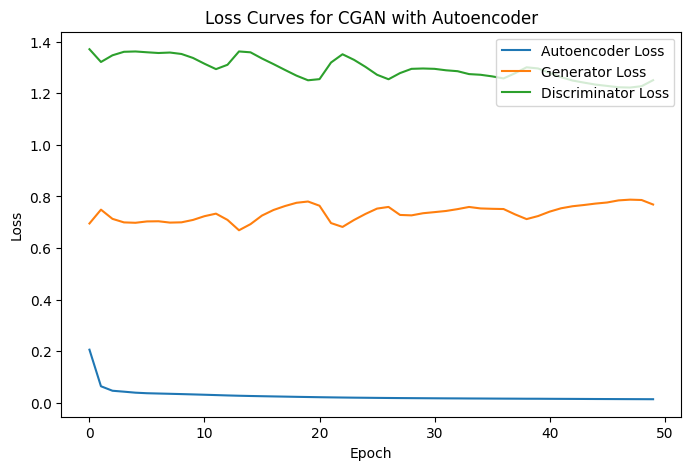

In [81]:
#best paremetes:
batch_size = int(batch_size)

noise_dim = noise_dim
num_epochs = num_epochs
batch_size = batch_size

autoencoder, generator, ae_losses, gen_losses, disc_losses = train_cgan_autoencoder(
    X_train_preprocessed, y_train_onehot,
    noise_dim,
    embed_dim,
    num_epochs,
    batch_size,
    device,
    seed,
    gen_lr,
    disc_lr
)

# Plot the recorded losses
plt.figure(figsize=(8, 5))
plt.plot(ae_losses, label="Autoencoder Loss")
plt.plot(gen_losses, label="Generator Loss")
plt.plot(disc_losses, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves for CGAN with Autoencoder")
plt.legend()
plt.show()


In [82]:
# After the training loop finishes
generator.eval()  # Ensure the generator is in evaluation mode
autoencoder.eval()  # Ensure the autoencoder is in evaluation mode

# 1) Determine the number of synthetic samples (match training dataset size)
num_synthetic_samples = X_train_preprocessed.shape[0]

# Fix the random seed for reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

noise = torch.randn((num_synthetic_samples, noise_dim), device=device) * 0.5

# 2) Prepare conditional labels for synthetic data
synthetic_labels = torch.tensor(y_train_onehot).float().to(device)

# 3) Generate synthetic embeddings using the generator with conditional labels
with torch.no_grad():
    synthetic_embeddings = generator(noise, synthetic_labels)

# 4) Decode the embeddings to reconstruct synthetic data with conditional labels
with torch.no_grad():
    synthetic_data_tensor = autoencoder.decoder(torch.cat([synthetic_embeddings, synthetic_labels], dim=1))

# 5) Convert the synthetic data to a NumPy array for post-processing
synthetic_data = synthetic_data_tensor.cpu().numpy()

# Print the shape of the synthetic dataset
print(f"Synthetic dataset generated with shape: {synthetic_data.shape}")

synthetic_data_copy = synthetic_data.copy()


Synthetic dataset generated with shape: (26048, 108)


In [83]:
# Fix the random seed for reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Separate continuous and categorical features based on training data
num_continuous_features = len(continuous_features)

# Extract continuous features
synthetic_continuous = synthetic_data[:, :num_continuous_features]

# Add slight noise to reduce overfitting while avoiding negative values
synthetic_continuous += np.random.normal(0, 0.05, synthetic_continuous.shape)
synthetic_continuous = scaler.inverse_transform(synthetic_continuous)

# Ensure no negative values for specific continuous features
non_negative_features = ['capital-gain', 'capital-loss']
for feature in non_negative_features:
    if feature in continuous_features:
        feature_index = continuous_features.index(feature)
        synthetic_continuous[:, feature_index] = np.clip(synthetic_continuous[:, feature_index], 0, None)

# Extract categorical features and reverse one-hot encoding
synthetic_categorical_data = synthetic_data[:, num_continuous_features:]
synthetic_categorical = oh_encoder.inverse_transform(synthetic_categorical_data)

# Ensure correct formatting of categorical data
synthetic_categorical_df = pd.DataFrame(synthetic_categorical, columns=categorical_features)

# Introduce diversity to categorical features using real data distribution
for col in categorical_features:
    unique_values = X_train_1[col].dropna().unique()
    probabilities = X_train_1[col].value_counts(normalize=True).to_dict()
    valid_values = [val for val in unique_values if val in probabilities]

    synthetic_categorical_df[col] = np.random.choice(
        valid_values,
        size=len(synthetic_categorical_df),
        replace=True,
        p=[probabilities[val] for val in valid_values]
    )

# Shuffle categorical values to introduce diversity
synthetic_categorical_df = synthetic_categorical_df.sample(frac=1).reset_index(drop=True)

# Combine continuous and categorical features
synthetic_combined = np.hstack([synthetic_continuous, synthetic_categorical_df])

# Create final synthetic DataFrame
synthetic_df = pd.DataFrame(
    synthetic_combined,
    columns=continuous_features + categorical_features
)

# Convert categorical columns to their original types
for col in categorical_features:
    synthetic_df[col] = synthetic_df[col].astype(str)

# Print the shape and preview the synthetic dataset
print(f"Synthetic Dataset Shape (Post-Processed): {synthetic_df.shape}")
print(synthetic_df.head())

synthetic_df_copy = synthetic_df.copy()


Synthetic Dataset Shape (Post-Processed): (26048, 14)
         age        fnlwgt education-num capital-gain capital-loss  \
0  37.600945      356456.0      8.835017          0.0   189.181259   
1  44.775883    308414.125      8.809912          0.0   318.868774   
2  46.434608      359006.0      8.774063          0.0          0.0   
3  45.090862  445770.28125      7.369787  5736.120605     197.5112   
4  47.808384     283506.75     11.423053          0.0          0.0   

  hours-per-week     workclass  education      marital-status  \
0      31.402803       Private    Masters  Married-civ-spouse   
1      31.034683       Private  Bachelors  Married-civ-spouse   
2      40.033123  Self-emp-inc        9th       Never-married   
3      44.942142       Private  Assoc-voc  Married-civ-spouse   
4      51.162922       Private    HS-grad  Married-civ-spouse   

          occupation   relationship   race     sex native-country  
0  Handlers-cleaners           Wife  Black    Male  United-States 

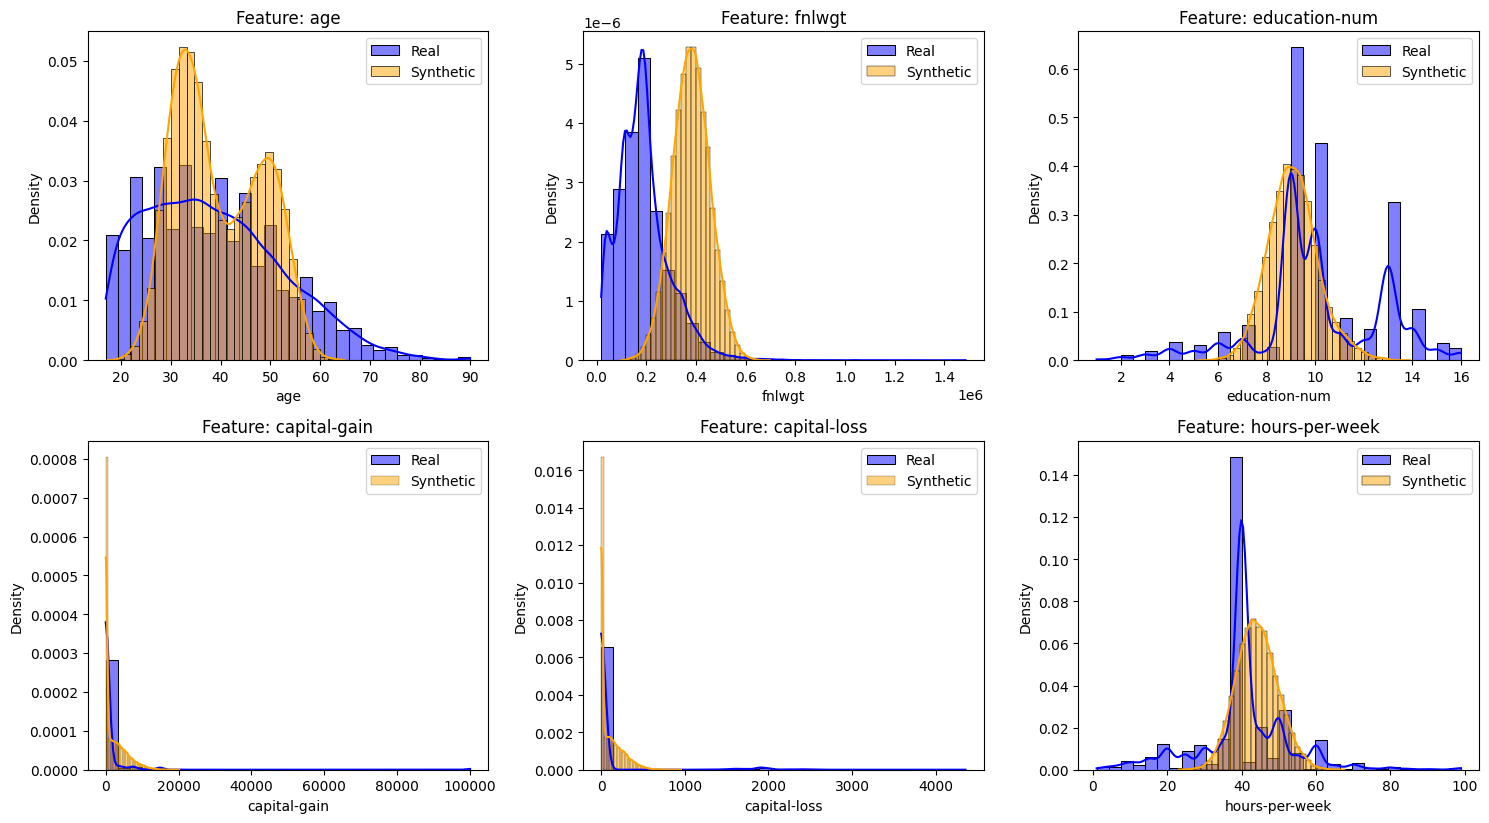

In [84]:
# Number of features
num_features = len(continuous_features)

# Create a grid of subplots
fig, axes = plt.subplots(nrows=(num_features // 3) + 1, ncols=3, figsize=(15, num_features * 2))

# Flatten axes for easier iteration
axes = axes.flatten()

# Loop through each feature
for idx, feature in enumerate(continuous_features):
    ax = axes[idx]

    # Real data column
    real_data_col = X_train_1[feature]  # Adjust if the real data structure differs
    sns.histplot(real_data_col, color='blue', kde=True, label='Real', stat='density', bins=30, ax=ax)

    # Synthetic data column from synthetic_df_copy
    synthetic_data_col = synthetic_df_copy[feature]
    sns.histplot(synthetic_data_col, color='orange', kde=True, label='Synthetic', stat='density', bins=30, ax=ax)

    # Set title and labels
    ax.set_title(f"Feature: {feature}")
    ax.set_xlabel(feature)
    ax.set_ylabel("Density")
    ax.legend()

# Remove any unused subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


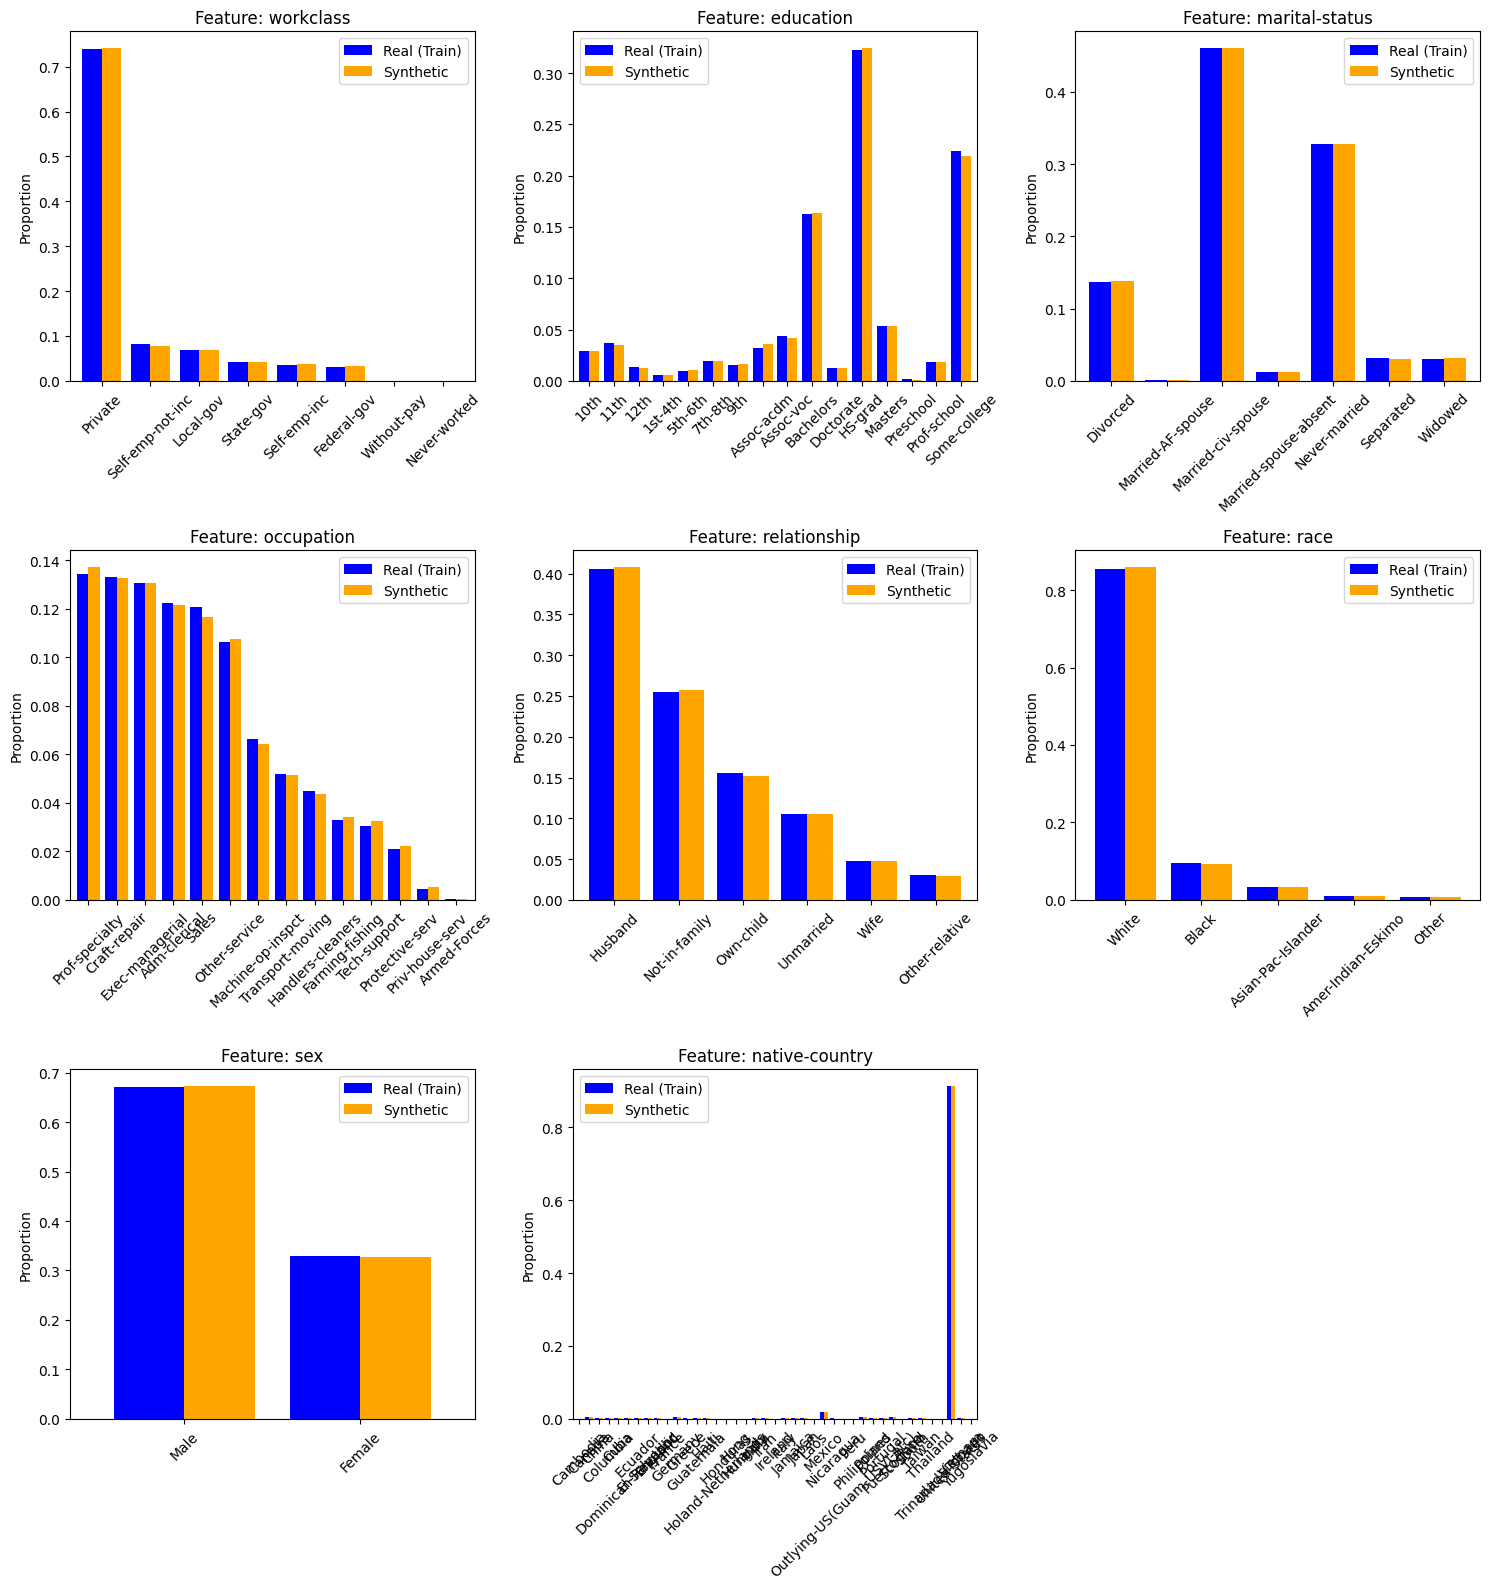

In [85]:
# Number of features
num_features = len(categorical_features)

# Create a grid of subplots
fig, axes = plt.subplots(nrows=(num_features // 3) + 1, ncols=3, figsize=(15, num_features * 2))

# Flatten axes for easier iteration
axes = axes.flatten()

# Loop through each categorical feature
for idx, feature in enumerate(categorical_features):
    ax = axes[idx]

    # Real distribution
    real_counts = X_train_1[feature].value_counts(normalize=True)

    # Synthetic distribution
    synth_counts = synthetic_df_copy[feature].value_counts(normalize=True)

    # Combine and plot
    comparison_df = pd.DataFrame({'Real (Train)': real_counts, 'Synthetic': synth_counts}).fillna(0)
    comparison_df.plot(kind='bar', width=0.8, ax=ax, color=['blue', 'orange'])

    # Set title and labels
    ax.set_title(f"Feature: {feature}")
    ax.set_ylabel("Proportion")
    ax.set_xlabel("")
    ax.tick_params(axis='x', rotation=45)

    # Add legend
    ax.legend()

# Remove any unused subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


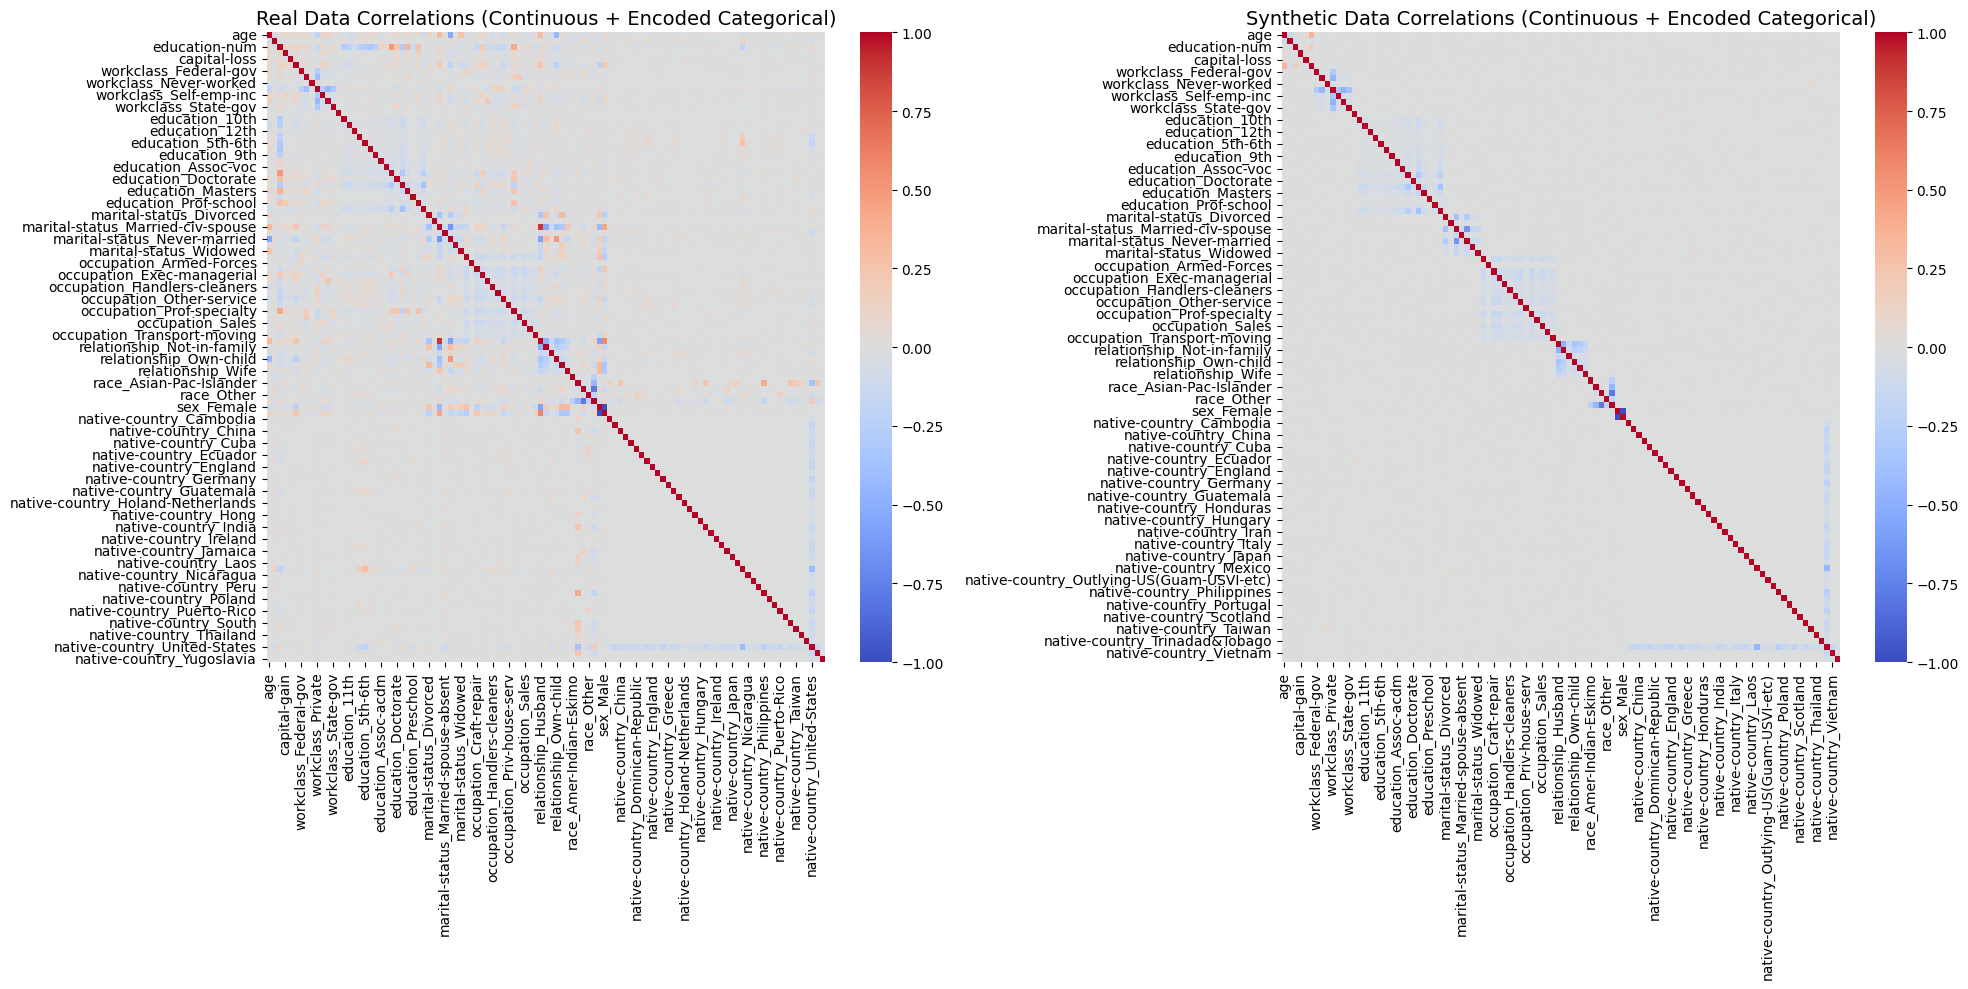

In [86]:
# Combine continuous and one-hot-encoded categorical features
combined_features = pd.concat(
    [X_train_1[continuous_features], pd.get_dummies(X_train_1[categorical_features], drop_first=False)],
    axis=1
)

# Calculate correlations for real data
real_corr = combined_features.corr()

# For synthetic data
synthetic_combined_features = pd.concat(
    [synthetic_df_copy[continuous_features], pd.get_dummies(synthetic_df_copy[categorical_features], drop_first=False)],
    axis=1
)
synthetic_corr = synthetic_combined_features.corr()

# Plot Side-by-Side Correlation Heatmaps
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Real Data Correlations
sns.heatmap(real_corr, ax=axes[0], cmap="coolwarm", cbar=True, annot=False)
axes[0].set_title("Real Data Correlations (Continuous + Encoded Categorical)", fontsize=14)

# Synthetic Data Correlations
sns.heatmap(synthetic_corr, ax=axes[1], cmap="coolwarm", cbar=True, annot=False)
axes[1].set_title("Synthetic Data Correlations (Continuous + Encoded Categorical)", fontsize=14)

plt.tight_layout()
plt.show()


second seed = 2

In [87]:
seed = 2

In [88]:
# --- 1. Scale continuous features using MinMaxScaler ---
# Fit the scaler on the original (unnormalized) continuous data
scaler = MinMaxScaler()

scaler.fit(X_train_2[continuous_features])  # Fit on the original data
X_train_cont_scaled = scaler.transform(X_train_2[continuous_features])
X_test_cont_scaled = scaler.transform(X_test_2[continuous_features])

# --- 2. Encode categorical features using OneHotEncoder ---
oh_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

X_train_cat_encoded = oh_encoder.fit_transform(X_train_2[categorical_features])
X_test_cat_encoded = oh_encoder.transform(X_test_2[categorical_features])

# --- 3. Combine scaled continuous features and one-hot categorical features ---
X_train_preprocessed = np.hstack([X_train_cont_scaled, X_train_cat_encoded])
X_test_preprocessed = np.hstack([X_test_cont_scaled, X_test_cat_encoded])

# Convert target labels to one-hot encoding
y_train_onehot = np.array(pd.get_dummies(y_train_2))

# Print the shapes to verify
print("Shapes after preprocessing:")
print("X_train_preprocessed shape:", X_train_preprocessed.shape)
print("X_test_preprocessed  shape:", X_test_preprocessed.shape)
print("y_train_onehot shape:", y_train_onehot.shape)


Shapes after preprocessing:
X_train_preprocessed shape: (26048, 108)
X_test_preprocessed  shape: (6513, 108)
y_train_onehot shape: (26048, 2)


In [89]:
# Fixed parameters
gen_lr = 0.0001  # Generator learning rate
disc_lr = 0.00001  # Discriminator learning rate
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embed_dim = 64  # Size of the latent embedding space

# Parameters for the experiments
batch_sizes = [128, 256, 512]
num_epochs_list = [30, 50]
noise_dims = [100, 200]

# Placeholder for results
results = []

# Perform experiments
for batch_size in batch_sizes:
    for num_epochs in num_epochs_list:
        for noise_dim in noise_dims:
            # Train the models
            autoencoder, generator, ae_losses, gen_losses, disc_losses = train_cgan_autoencoder(
                X_train_preprocessed, y_train_onehot, noise_dim, embed_dim=embed_dim, num_epochs=num_epochs,
                batch_size=batch_size, device=device, seed=seed, gen_lr=gen_lr, disc_lr=disc_lr
            )

            # After the training loop finishes
            generator.eval()  # Ensure the generator is in evaluation mode
            autoencoder.eval()  # Ensure the autoencoder is in evaluation mode

            # Determine the number of synthetic samples (match training dataset size)
            num_synthetic_samples = X_train_preprocessed.shape[0]
            # Fix the random seed for reproducibility
            random.seed(seed)  # For Python's random module
            np.random.seed(seed)  # For numpy random functions
            torch.manual_seed(seed)  # For PyTorch random functions (if used)
            torch.cuda.manual_seed_all(seed)

            noise = torch.randn((num_synthetic_samples, noise_dim), device=device) * 0.5


            # Prepare conditional labels for synthetic data
            synthetic_labels = torch.tensor(y_train_onehot).float().to(device)

            # Generate synthetic embeddings using the generator with conditional labels
            with torch.no_grad():
                synthetic_embeddings = generator(noise, synthetic_labels)

            # Decode the embeddings to reconstruct synthetic data with conditional labels
            with torch.no_grad():
                synthetic_data_tensor = autoencoder.decoder(
                    torch.cat([synthetic_embeddings, synthetic_labels], dim=1)
                )

            # Convert the synthetic data to a NumPy array for post-processing
            synthetic_data = synthetic_data_tensor.cpu().numpy()

            # Calculate metrics
            auc_real, auc_synth, efficacy_ratio = efficacy_metric(
                X_train_preprocessed, y_train_2, X_test_preprocessed, y_test_2, synthetic_data, seed
            )

            real_data_80 = X_train_preprocessed[:int(0.8 * X_train_preprocessed.shape[0])]
            synthetic_data_80 = synthetic_data[:real_data_80.shape[0]]
            detection_auc = detection_metric(real_data_80, synthetic_data_80, seed)

            # Append results to the list
            results.append({
                "Batch Size": batch_size,
                "Num Epochs": num_epochs,
                "Noise Dim": noise_dim,
                "Real->Real AUC": auc_real,
                "Synthetic->Real AUC": auc_synth,
                "Efficacy Ratio": efficacy_ratio,
                "Detection AUC": detection_auc,
                "Synthetic Data Shape": synthetic_data.shape
            })

# Create DataFrame from results
results_df_second_seed = pd.DataFrame(results)

# Display the results
def display_results(df):
    print(df.head())  # Replace with an actual visualization or export logic if needed

# Display or return the results DataFrame
display_results(results_df_second_seed)


Epoch: 1 Step: 0 Gen Loss: 0.6850 Disc Fake Loss: 0.7167 Disc Real Loss: 0.7275 Disc Total Loss: 1.4442 AE Loss: 0.2458
Epoch: 1 Step: 50 Gen Loss: 0.7241 Disc Fake Loss: 0.6641 Disc Real Loss: 0.7059 Disc Total Loss: 1.3700 AE Loss: 0.2177
Epoch: 1 Step: 100 Gen Loss: 0.7538 Disc Fake Loss: 0.6439 Disc Real Loss: 0.7055 Disc Total Loss: 1.3494 AE Loss: 0.1038
Epoch: 1 Step: 150 Gen Loss: 0.7446 Disc Fake Loss: 0.6494 Disc Real Loss: 0.6962 Disc Total Loss: 1.3456 AE Loss: 0.0538
Epoch: 1 Step: 200 Gen Loss: 0.7236 Disc Fake Loss: 0.6633 Disc Real Loss: 0.6952 Disc Total Loss: 1.3585 AE Loss: 0.0479
Epoch: 1 Step: 0 Gen Loss: 0.7357 Disc Total Loss: 1.3610 AE Loss: 0.1288
Epoch: 2 Step: 0 Gen Loss: 0.7233 Disc Fake Loss: 0.6637 Disc Real Loss: 0.6951 Disc Total Loss: 1.3587 AE Loss: 0.0473
Epoch: 2 Step: 50 Gen Loss: 0.7165 Disc Fake Loss: 0.6753 Disc Real Loss: 0.6816 Disc Total Loss: 1.3568 AE Loss: 0.0441
Epoch: 2 Step: 100 Gen Loss: 0.7100 Disc Fake Loss: 0.6806 Disc Real Loss: 0.6

In [90]:
# Order the results DataFrame by "Efficacy Ratio" in descending order
results_df_second_seed = results_df_second_seed.sort_values(by="Efficacy Ratio", ascending=False)

# Save DataFrame to CSV
csv_file_path = "experiment_results_second_seed_cgan.csv"
results_df_second_seed.to_csv(csv_file_path, index=False)

print(f"Results saved to {csv_file_path}")

print(results_df_second_seed.head(1))

Results saved to experiment_results_second_seed_cgan.csv
   Batch Size  Num Epochs  Noise Dim  Real->Real AUC  Synthetic->Real AUC  \
3         128          50        200        0.905971             0.819397   

   Efficacy Ratio  Detection AUC Synthetic Data Shape  
3        0.904441            1.0         (26048, 108)  


In [91]:
# Extract the top row
top_result = results_df_second_seed.iloc[0]

# Extract individual values
batch_size = top_result["Batch Size"]
num_epochs = top_result["Num Epochs"]
noise_dim = top_result["Noise Dim"]
auc_real = top_result["Real->Real AUC"]
auc_synth = top_result["Synthetic->Real AUC"]
efficacy_ratio = top_result["Efficacy Ratio"]
detection_auc = top_result["Detection AUC"]

# Print results in your desired format
print(f"Detection Metric (Average AUC): {detection_auc:.4f}")
print(f"Real->Real AUC: {auc_real:.4f}")
print(f"Synthetic->Real AUC: {auc_synth:.4f}")
print(f"Efficacy Ratio: {efficacy_ratio:.4f}")
print(" ")
print(f"Batch Size: {batch_size}, Num Epochs: {num_epochs}, Noise Dim: {noise_dim} ")


efficacy_ratio_second_seed = efficacy_ratio
detection_auc_second_seed = detection_auc



Detection Metric (Average AUC): 1.0000
Real->Real AUC: 0.9060
Synthetic->Real AUC: 0.8194
Efficacy Ratio: 0.9044
 
Batch Size: 128, Num Epochs: 50, Noise Dim: 200 


Epoch: 1 Step: 0 Gen Loss: 0.6520 Disc Fake Loss: 0.7315 Disc Real Loss: 0.6542 Disc Total Loss: 1.3857 AE Loss: 0.2457
Epoch: 1 Step: 50 Gen Loss: 0.7071 Disc Fake Loss: 0.6814 Disc Real Loss: 0.6851 Disc Total Loss: 1.3666 AE Loss: 0.2179
Epoch: 1 Step: 100 Gen Loss: 0.7232 Disc Fake Loss: 0.6653 Disc Real Loss: 0.6796 Disc Total Loss: 1.3449 AE Loss: 0.1042
Epoch: 1 Step: 150 Gen Loss: 0.7245 Disc Fake Loss: 0.6731 Disc Real Loss: 0.6703 Disc Total Loss: 1.3434 AE Loss: 0.0537
Epoch: 1 Step: 200 Gen Loss: 0.7042 Disc Fake Loss: 0.6828 Disc Real Loss: 0.6760 Disc Total Loss: 1.3588 AE Loss: 0.0491
Epoch: 1 Step: 0 Gen Loss: 0.7105 Disc Total Loss: 1.3574 AE Loss: 0.1287
Epoch: 2 Step: 0 Gen Loss: 0.7072 Disc Fake Loss: 0.6827 Disc Real Loss: 0.6759 Disc Total Loss: 1.3586 AE Loss: 0.0475
Epoch: 2 Step: 50 Gen Loss: 0.7033 Disc Fake Loss: 0.6864 Disc Real Loss: 0.6720 Disc Total Loss: 1.3584 AE Loss: 0.0448
Epoch: 2 Step: 100 Gen Loss: 0.6940 Disc Fake Loss: 0.6890 Disc Real Loss: 0.6

Epoch: 29 Step: 100 Gen Loss: 0.7889 Disc Fake Loss: 0.6304 Disc Real Loss: 0.6097 Disc Total Loss: 1.2401 AE Loss: 0.0130
Epoch: 29 Step: 150 Gen Loss: 0.7797 Disc Fake Loss: 0.6253 Disc Real Loss: 0.6260 Disc Total Loss: 1.2512 AE Loss: 0.0133
Epoch: 29 Step: 200 Gen Loss: 0.7793 Disc Fake Loss: 0.6138 Disc Real Loss: 0.6107 Disc Total Loss: 1.2245 AE Loss: 0.0125
Epoch: 29 Step: 0 Gen Loss: 0.7849 Disc Total Loss: 1.2398 AE Loss: 0.0137
Epoch: 30 Step: 0 Gen Loss: 0.8023 Disc Fake Loss: 0.6208 Disc Real Loss: 0.6070 Disc Total Loss: 1.2278 AE Loss: 0.0138
Epoch: 30 Step: 50 Gen Loss: 0.7854 Disc Fake Loss: 0.6177 Disc Real Loss: 0.6065 Disc Total Loss: 1.2242 AE Loss: 0.0128
Epoch: 30 Step: 100 Gen Loss: 0.7935 Disc Fake Loss: 0.6170 Disc Real Loss: 0.5987 Disc Total Loss: 1.2157 AE Loss: 0.0134
Epoch: 30 Step: 150 Gen Loss: 0.8092 Disc Fake Loss: 0.6127 Disc Real Loss: 0.6031 Disc Total Loss: 1.2158 AE Loss: 0.0114
Epoch: 30 Step: 200 Gen Loss: 0.7948 Disc Fake Loss: 0.6203 Disc Re

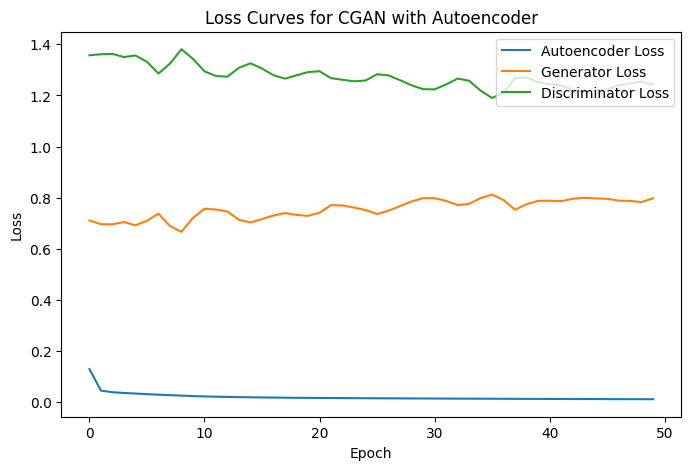

In [92]:
#best paremetes:
batch_size = int(batch_size)

noise_dim = noise_dim
num_epochs = num_epochs
batch_size = batch_size


autoencoder, generator, ae_losses, gen_losses, disc_losses = train_cgan_autoencoder(
    X_train_preprocessed, y_train_onehot,
    noise_dim,
    embed_dim,
    num_epochs,
    batch_size,
    device,
    seed,
    gen_lr,
    disc_lr
)

# Plot the recorded losses
plt.figure(figsize=(8, 5))
plt.plot(ae_losses, label="Autoencoder Loss")
plt.plot(gen_losses, label="Generator Loss")
plt.plot(disc_losses, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves for CGAN with Autoencoder")
plt.legend()
plt.show()


In [93]:
# After the training loop finishes
generator.eval()  # Ensure the generator is in evaluation mode
autoencoder.eval()  # Ensure the autoencoder is in evaluation mode

# 1) Determine the number of synthetic samples (match training dataset size)
num_synthetic_samples = X_train_preprocessed.shape[0]

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

noise = torch.randn((num_synthetic_samples, noise_dim), device=device) * 0.5


# 2) Prepare conditional labels for synthetic data
synthetic_labels = torch.tensor(y_train_onehot).float().to(device)

# 3) Generate synthetic embeddings using the generator with conditional labels
with torch.no_grad():
    synthetic_embeddings = generator(noise, synthetic_labels)

# 4) Decode the embeddings to reconstruct synthetic data with conditional labels
with torch.no_grad():
    synthetic_data_tensor = autoencoder.decoder(torch.cat([synthetic_embeddings, synthetic_labels], dim=1))

# 5) Convert the synthetic data to a NumPy array for post-processing
synthetic_data = synthetic_data_tensor.cpu().numpy()

# Print the shape of the synthetic dataset
print(f"Synthetic dataset generated with shape: {synthetic_data.shape}")

synthetic_data_copy = synthetic_data.copy()


Synthetic dataset generated with shape: (26048, 108)


In [94]:
# Fix the random seed for reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Separate continuous and categorical features based on training data
num_continuous_features = len(continuous_features)

# Extract continuous features
synthetic_continuous = synthetic_data[:, :num_continuous_features]

# Add slight noise to reduce overfitting while avoiding negative values
synthetic_continuous += np.random.normal(0, 0.05, synthetic_continuous.shape)
synthetic_continuous = scaler.inverse_transform(synthetic_continuous)

# Ensure no negative values for specific continuous features
non_negative_features = ['capital-gain', 'capital-loss']
for feature in non_negative_features:
    if feature in continuous_features:
        feature_index = continuous_features.index(feature)
        synthetic_continuous[:, feature_index] = np.clip(synthetic_continuous[:, feature_index], 0, None)

# Extract categorical features and reverse one-hot encoding
synthetic_categorical_data = synthetic_data[:, num_continuous_features:]
synthetic_categorical = oh_encoder.inverse_transform(synthetic_categorical_data)

# Ensure correct formatting of categorical data
synthetic_categorical_df = pd.DataFrame(synthetic_categorical, columns=categorical_features)

# Introduce diversity to categorical features using real data distribution
for col in categorical_features:
    unique_values = X_train_2[col].dropna().unique()
    probabilities = X_train_2[col].value_counts(normalize=True).to_dict()
    valid_values = [val for val in unique_values if val in probabilities]

    synthetic_categorical_df[col] = np.random.choice(
        valid_values,
        size=len(synthetic_categorical_df),
        replace=True,
        p=[probabilities[val] for val in valid_values]
    )

# Shuffle categorical values to introduce diversity
synthetic_categorical_df = synthetic_categorical_df.sample(frac=1).reset_index(drop=True)

# Combine continuous and categorical features
synthetic_combined = np.hstack([synthetic_continuous, synthetic_categorical_df])

# Create final synthetic DataFrame
synthetic_df = pd.DataFrame(
    synthetic_combined,
    columns=continuous_features + categorical_features
)

# Convert categorical columns to their original types
for col in categorical_features:
    synthetic_df[col] = synthetic_df[col].astype(str)

# Print the shape and preview the synthetic dataset
print(f"Synthetic Dataset Shape (Post-Processed): {synthetic_df.shape}")
print(synthetic_df.head())

synthetic_df_copy = synthetic_df.copy()


Synthetic Dataset Shape (Post-Processed): (26048, 14)
         age        fnlwgt education-num capital-gain capital-loss  \
0  44.393665    319903.125      7.753479  8206.092773          0.0   
1  44.887951  344045.53125      8.232229          0.0   162.238144   
2  51.330673  315837.65625      9.199175          0.0    84.992523   
3  43.395905  314341.96875      8.687702          0.0    71.743057   
4  31.867819  322794.96875      8.313666          0.0          0.0   

  hours-per-week workclass  education      marital-status       occupation  \
0      38.247002   Private  Bachelors       Never-married  Farming-fishing   
1      53.700031   Private    HS-grad       Never-married    Other-service   
2      47.048485   Private  Bachelors  Married-civ-spouse            Sales   
3      37.191723   Private    HS-grad       Never-married  Farming-fishing   
4      44.405766   Private       11th  Married-civ-spouse            Sales   

    relationship   race     sex native-country  
0  Not-

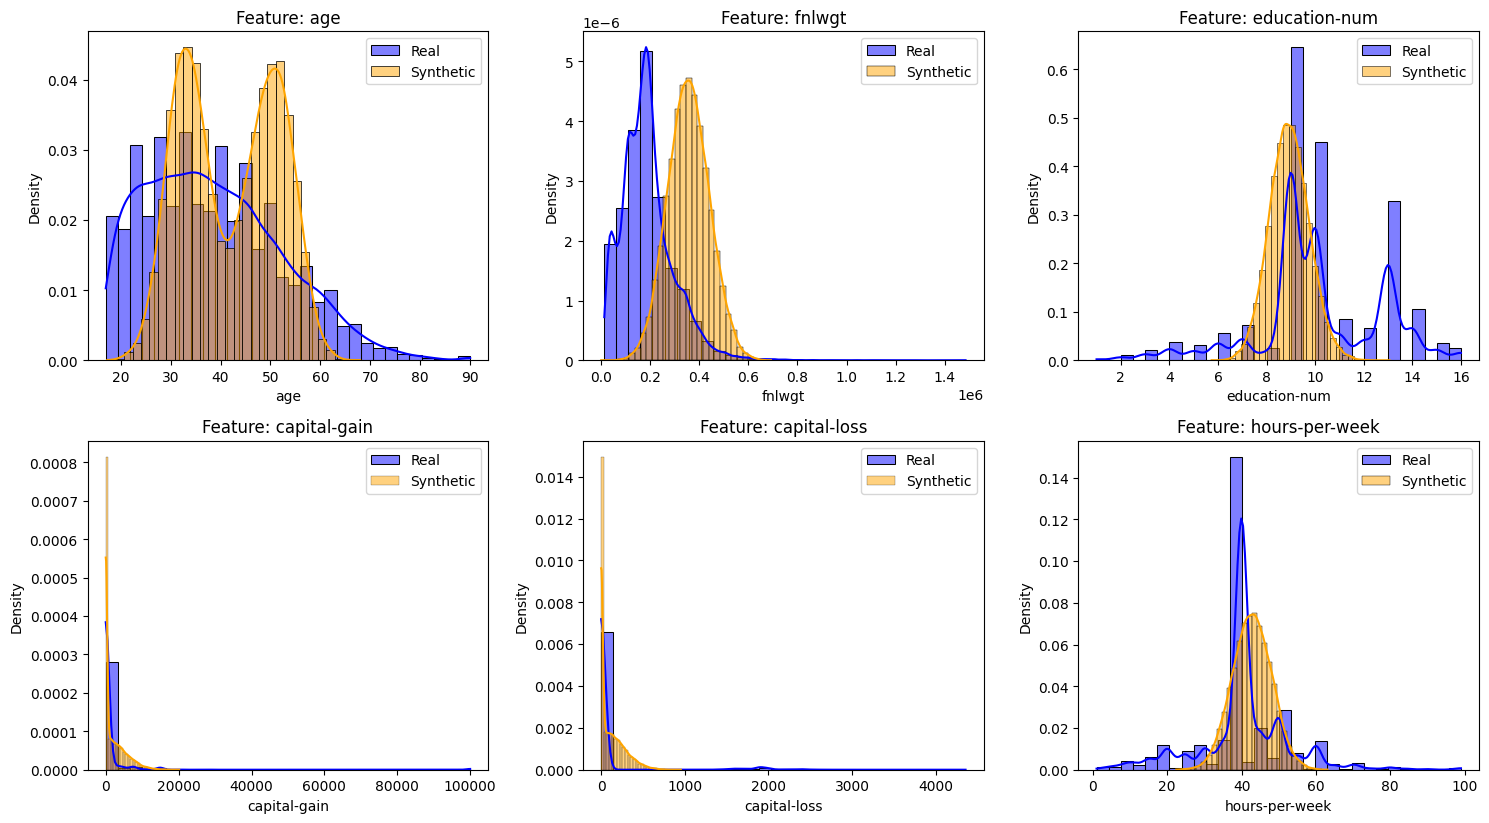

In [95]:
# Number of features
num_features = len(continuous_features)

# Create a grid of subplots
fig, axes = plt.subplots(nrows=(num_features // 3) + 1, ncols=3, figsize=(15, num_features * 2))

# Flatten axes for easier iteration
axes = axes.flatten()

# Loop through each feature
for idx, feature in enumerate(continuous_features):
    ax = axes[idx]

    # Real data column
    real_data_col = X_train_2[feature]  # Adjust if the real data structure differs
    sns.histplot(real_data_col, color='blue', kde=True, label='Real', stat='density', bins=30, ax=ax)

    # Synthetic data column from synthetic_df_copy
    synthetic_data_col = synthetic_df_copy[feature]
    sns.histplot(synthetic_data_col, color='orange', kde=True, label='Synthetic', stat='density', bins=30, ax=ax)

    # Set title and labels
    ax.set_title(f"Feature: {feature}")
    ax.set_xlabel(feature)
    ax.set_ylabel("Density")
    ax.legend()

# Remove any unused subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


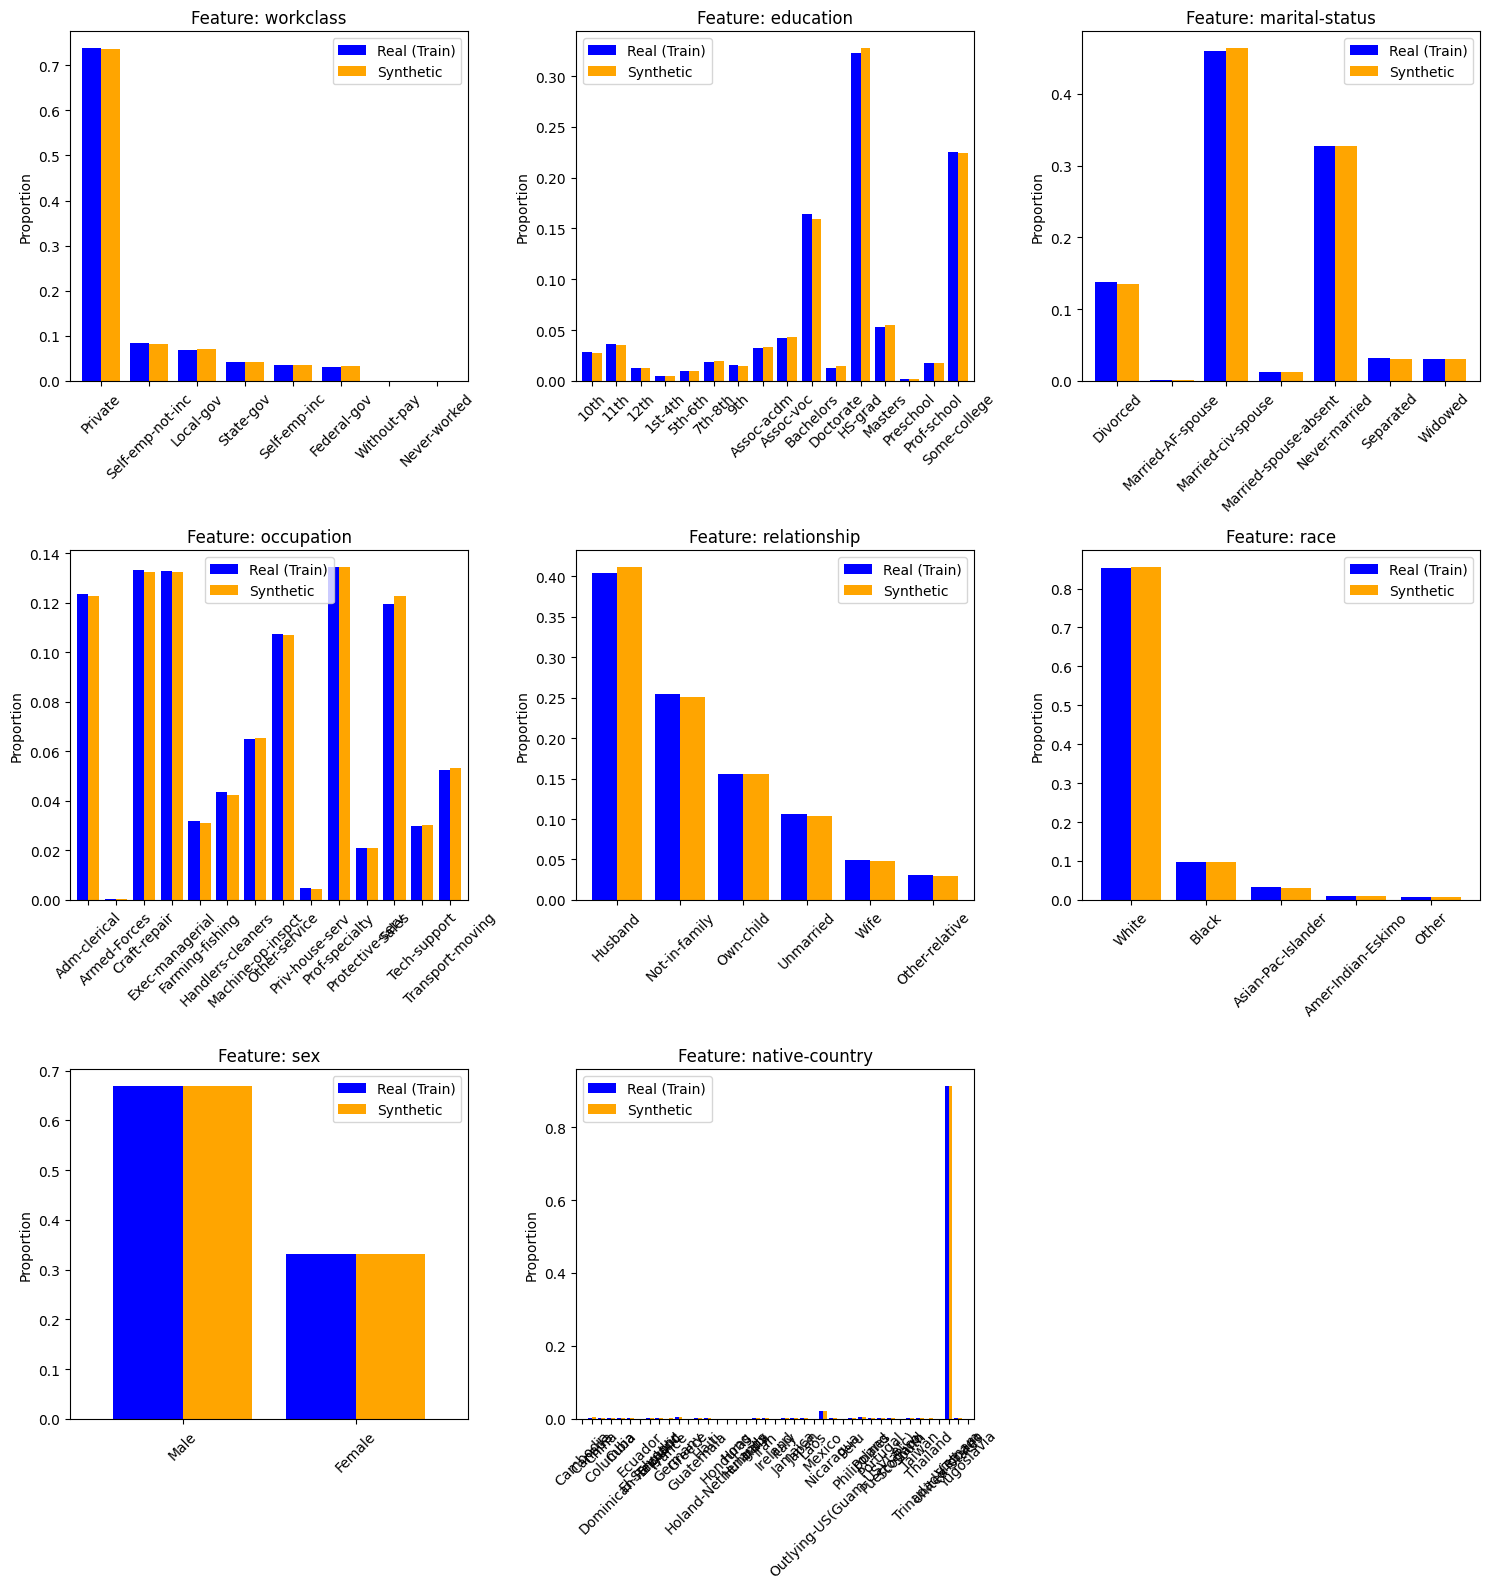

In [96]:
# Number of features
num_features = len(categorical_features)

# Create a grid of subplots
fig, axes = plt.subplots(nrows=(num_features // 3) + 1, ncols=3, figsize=(15, num_features * 2))

# Flatten axes for easier iteration
axes = axes.flatten()

# Loop through each categorical feature
for idx, feature in enumerate(categorical_features):
    ax = axes[idx]

    # Real distribution
    real_counts = X_train_2[feature].value_counts(normalize=True)

    # Synthetic distribution
    synth_counts = synthetic_df_copy[feature].value_counts(normalize=True)

    # Combine and plot
    comparison_df = pd.DataFrame({'Real (Train)': real_counts, 'Synthetic': synth_counts}).fillna(0)
    comparison_df.plot(kind='bar', width=0.8, ax=ax, color=['blue', 'orange'])

    # Set title and labels
    ax.set_title(f"Feature: {feature}")
    ax.set_ylabel("Proportion")
    ax.set_xlabel("")
    ax.tick_params(axis='x', rotation=45)

    # Add legend
    ax.legend()

# Remove any unused subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


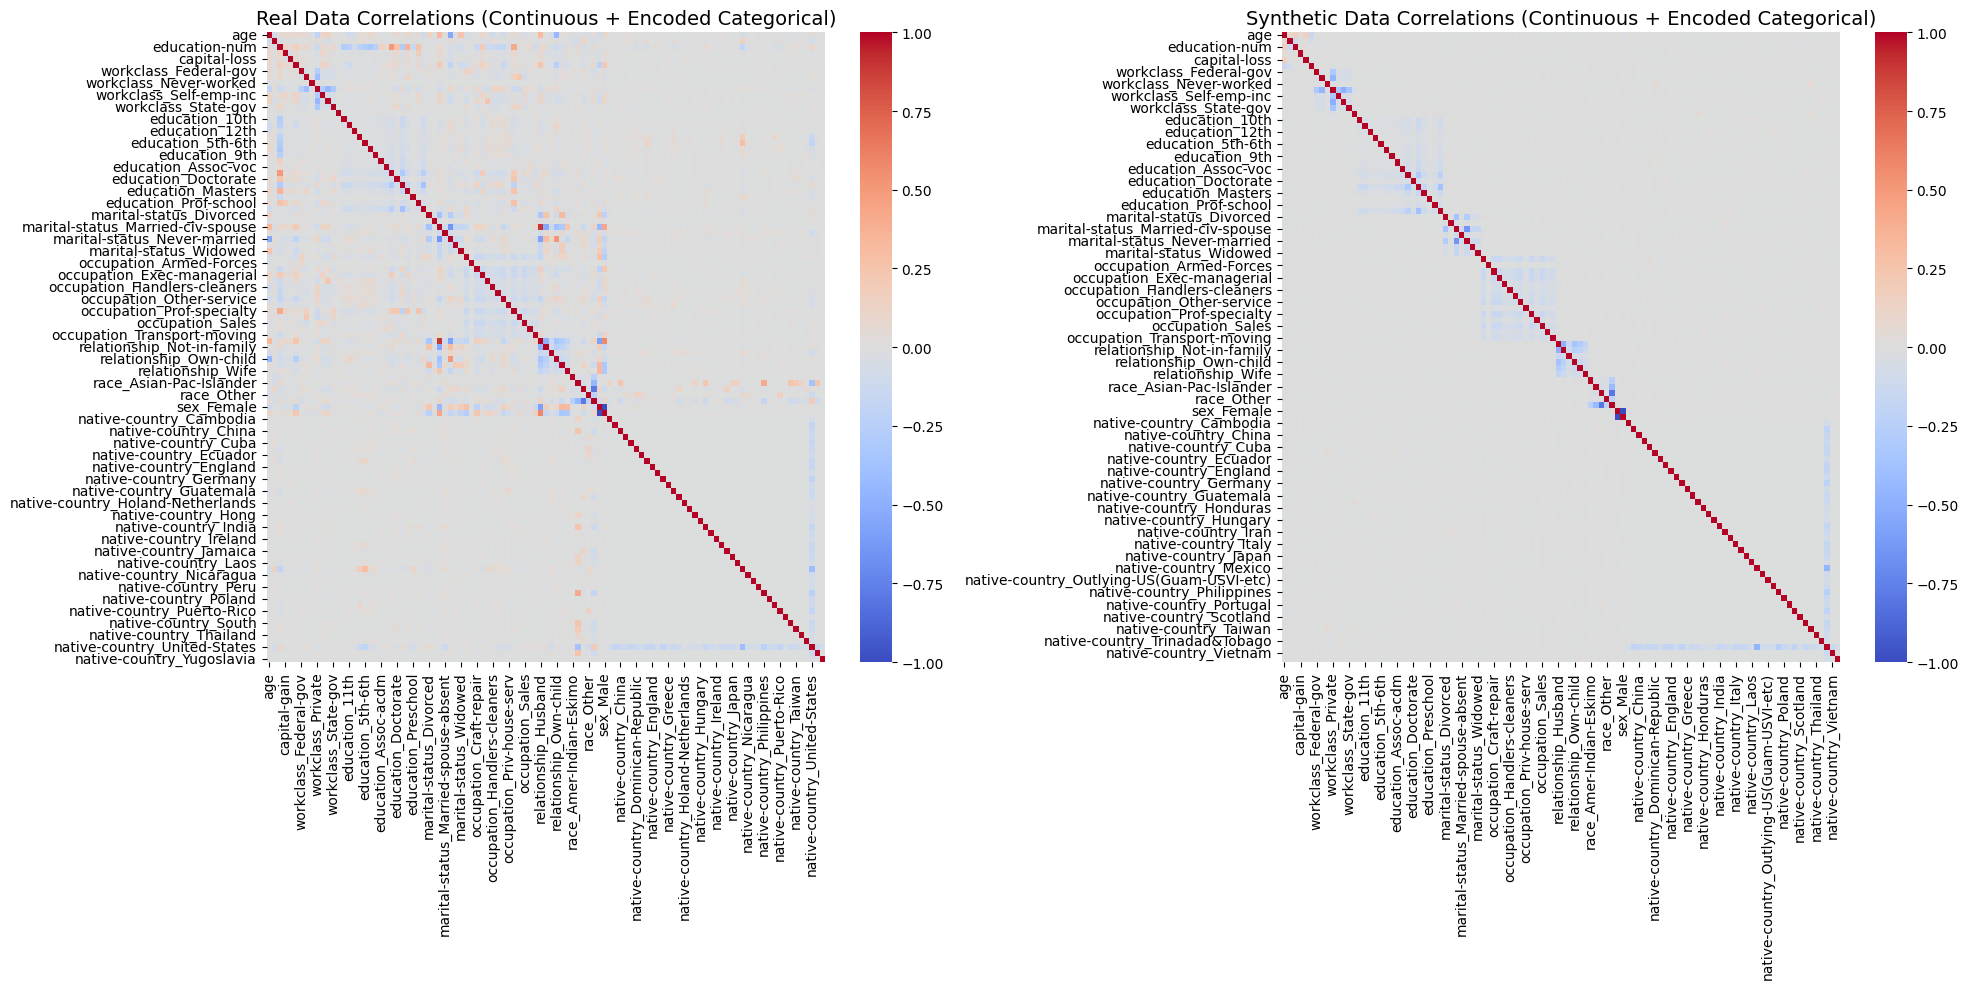

In [97]:
# Combine continuous and one-hot-encoded categorical features
combined_features = pd.concat(
    [X_train_2[continuous_features], pd.get_dummies(X_train_1[categorical_features], drop_first=False)],
    axis=1
)

# Calculate correlations for real data
real_corr = combined_features.corr()

# For synthetic data
synthetic_combined_features = pd.concat(
    [synthetic_df_copy[continuous_features], pd.get_dummies(synthetic_df_copy[categorical_features], drop_first=False)],
    axis=1
)
synthetic_corr = synthetic_combined_features.corr()

# Plot Side-by-Side Correlation Heatmaps
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Real Data Correlations
sns.heatmap(real_corr, ax=axes[0], cmap="coolwarm", cbar=True, annot=False)
axes[0].set_title("Real Data Correlations (Continuous + Encoded Categorical)", fontsize=14)

# Synthetic Data Correlations
sns.heatmap(synthetic_corr, ax=axes[1], cmap="coolwarm", cbar=True, annot=False)
axes[1].set_title("Synthetic Data Correlations (Continuous + Encoded Categorical)", fontsize=14)

plt.tight_layout()
plt.show()


third seed = 3

In [98]:
seed = 3

In [99]:
# --- 1. Scale continuous features using MinMaxScaler ---
# Fit the scaler on the original (unnormalized) continuous data
scaler = MinMaxScaler()

scaler.fit(X_train_3[continuous_features])  # Fit on the original data
X_train_cont_scaled = scaler.transform(X_train_3[continuous_features])
X_test_cont_scaled = scaler.transform(X_test_3[continuous_features])

# --- 2. Encode categorical features using OneHotEncoder ---
oh_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

X_train_cat_encoded = oh_encoder.fit_transform(X_train_3[categorical_features])
X_test_cat_encoded = oh_encoder.transform(X_test_3[categorical_features])

# --- 3. Combine scaled continuous features and one-hot categorical features ---
X_train_preprocessed = np.hstack([X_train_cont_scaled, X_train_cat_encoded])
X_test_preprocessed = np.hstack([X_test_cont_scaled, X_test_cat_encoded])

# Convert target labels to one-hot encoding
y_train_onehot = np.array(pd.get_dummies(y_train_3))

# Print the shapes to verify
print("Shapes after preprocessing:")
print("X_train_preprocessed shape:", X_train_preprocessed.shape)
print("X_test_preprocessed  shape:", X_test_preprocessed.shape)
print("y_train_onehot shape:", y_train_onehot.shape)


Shapes after preprocessing:
X_train_preprocessed shape: (26048, 108)
X_test_preprocessed  shape: (6513, 108)
y_train_onehot shape: (26048, 2)


In [100]:
# Fixed parameters
gen_lr = 0.0001  # Generator learning rate
disc_lr = 0.00001  # Discriminator learning rate
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embed_dim = 64  # Size of the latent embedding space

# Parameters for the experiments
batch_sizes = [128, 256, 512]
num_epochs_list = [30, 50]
noise_dims = [100, 200]

# Placeholder for results
results = []

# Perform experiments
for batch_size in batch_sizes:
    for num_epochs in num_epochs_list:
        for noise_dim in noise_dims:
            # Train the models
            autoencoder, generator, ae_losses, gen_losses, disc_losses = train_cgan_autoencoder(
                X_train_preprocessed, y_train_onehot, noise_dim, embed_dim=embed_dim, num_epochs=num_epochs,
                batch_size=batch_size, device=device, seed=seed, gen_lr=gen_lr, disc_lr=disc_lr
            )

            # After the training loop finishes
            generator.eval()  # Ensure the generator is in evaluation mode
            autoencoder.eval()  # Ensure the autoencoder is in evaluation mode

            # Determine the number of synthetic samples (match training dataset size)
            num_synthetic_samples = X_train_preprocessed.shape[0]
            # Fix the random seed for reproducibility
            random.seed(seed)  # For Python's random module
            np.random.seed(seed)  # For numpy random functions
            torch.manual_seed(seed)  # For PyTorch random functions (if used)
            torch.cuda.manual_seed_all(seed)

            noise = torch.randn((num_synthetic_samples, noise_dim), device=device) * 0.5


            # Prepare conditional labels for synthetic data
            synthetic_labels = torch.tensor(y_train_onehot).float().to(device)

            # Generate synthetic embeddings using the generator with conditional labels
            with torch.no_grad():
                synthetic_embeddings = generator(noise, synthetic_labels)

            # Decode the embeddings to reconstruct synthetic data with conditional labels
            with torch.no_grad():
                synthetic_data_tensor = autoencoder.decoder(
                    torch.cat([synthetic_embeddings, synthetic_labels], dim=1)
                )

            # Convert the synthetic data to a NumPy array for post-processing
            synthetic_data = synthetic_data_tensor.cpu().numpy()

            # Calculate metrics
            auc_real, auc_synth, efficacy_ratio = efficacy_metric(
                X_train_preprocessed, y_train_3, X_test_preprocessed, y_test_3, synthetic_data, seed
            )

            real_data_80 = X_train_preprocessed[:int(0.8 * X_train_preprocessed.shape[0])]
            synthetic_data_80 = synthetic_data[:real_data_80.shape[0]]
            detection_auc = detection_metric(real_data_80, synthetic_data_80, seed)

            # Append results to the list
            results.append({
                "Batch Size": batch_size,
                "Num Epochs": num_epochs,
                "Noise Dim": noise_dim,
                "Real->Real AUC": auc_real,
                "Synthetic->Real AUC": auc_synth,
                "Efficacy Ratio": efficacy_ratio,
                "Detection AUC": detection_auc,
                "Synthetic Data Shape": synthetic_data.shape
            })

# Create DataFrame from results
results_df_third_seed = pd.DataFrame(results)

# Display the results
def display_results(df):
    print(df.head())  # Replace with an actual visualization or export logic if needed

# Display or return the results DataFrame
display_results(results_df_third_seed)


Epoch: 1 Step: 0 Gen Loss: 0.7041 Disc Fake Loss: 0.6902 Disc Real Loss: 0.6816 Disc Total Loss: 1.3718 AE Loss: 0.2454
Epoch: 1 Step: 50 Gen Loss: 0.7416 Disc Fake Loss: 0.6613 Disc Real Loss: 0.6918 Disc Total Loss: 1.3532 AE Loss: 0.2194
Epoch: 1 Step: 100 Gen Loss: 0.7515 Disc Fake Loss: 0.6393 Disc Real Loss: 0.6847 Disc Total Loss: 1.3240 AE Loss: 0.1194
Epoch: 1 Step: 150 Gen Loss: 0.7320 Disc Fake Loss: 0.6520 Disc Real Loss: 0.6794 Disc Total Loss: 1.3314 AE Loss: 0.0550
Epoch: 1 Step: 200 Gen Loss: 0.7115 Disc Fake Loss: 0.6784 Disc Real Loss: 0.6854 Disc Total Loss: 1.3638 AE Loss: 0.0487
Epoch: 1 Step: 0 Gen Loss: 0.7335 Disc Total Loss: 1.3486 AE Loss: 0.1347
Epoch: 2 Step: 0 Gen Loss: 0.7088 Disc Fake Loss: 0.6799 Disc Real Loss: 0.6892 Disc Total Loss: 1.3690 AE Loss: 0.0492
Epoch: 2 Step: 50 Gen Loss: 0.7053 Disc Fake Loss: 0.6828 Disc Real Loss: 0.6790 Disc Total Loss: 1.3618 AE Loss: 0.0458
Epoch: 2 Step: 100 Gen Loss: 0.6946 Disc Fake Loss: 0.6897 Disc Real Loss: 0.6

Epoch: 3 Step: 50 Gen Loss: 0.7018 Disc Fake Loss: 0.6869 Disc Real Loss: 0.6852 Disc Total Loss: 1.3721 AE Loss: 0.0423
Epoch: 3 Step: 100 Gen Loss: 0.7026 Disc Fake Loss: 0.6888 Disc Real Loss: 0.6796 Disc Total Loss: 1.3685 AE Loss: 0.0410
Epoch: 3 Step: 150 Gen Loss: 0.7005 Disc Fake Loss: 0.6882 Disc Real Loss: 0.6795 Disc Total Loss: 1.3677 AE Loss: 0.0397
Epoch: 3 Step: 200 Gen Loss: 0.7016 Disc Fake Loss: 0.6832 Disc Real Loss: 0.6746 Disc Total Loss: 1.3578 AE Loss: 0.0382
Epoch: 3 Step: 0 Gen Loss: 0.7006 Disc Total Loss: 1.3666 AE Loss: 0.0412
Epoch: 4 Step: 0 Gen Loss: 0.7021 Disc Fake Loss: 0.6880 Disc Real Loss: 0.6803 Disc Total Loss: 1.3683 AE Loss: 0.0392
Epoch: 4 Step: 50 Gen Loss: 0.6980 Disc Fake Loss: 0.6829 Disc Real Loss: 0.6769 Disc Total Loss: 1.3598 AE Loss: 0.0369
Epoch: 4 Step: 100 Gen Loss: 0.7078 Disc Fake Loss: 0.6806 Disc Real Loss: 0.6819 Disc Total Loss: 1.3625 AE Loss: 0.0379
Epoch: 4 Step: 150 Gen Loss: 0.7084 Disc Fake Loss: 0.6802 Disc Real Loss: 0

In [101]:
# Order the results DataFrame by "Efficacy Ratio" in descending order
results_df_third_seed = results_df_third_seed.sort_values(by="Efficacy Ratio", ascending=False)

# Save DataFrame to CSV
csv_file_path = "experiment_results_third_seed_cgan.csv"
results_df_third_seed.to_csv(csv_file_path, index=False)

print(f"Results saved to {csv_file_path}")

print(results_df_third_seed.head(1))

Results saved to experiment_results_third_seed_cgan.csv
   Batch Size  Num Epochs  Noise Dim  Real->Real AUC  Synthetic->Real AUC  \
2         128          50        100         0.90928             0.839591   

   Efficacy Ratio  Detection AUC Synthetic Data Shape  
2        0.923358            1.0         (26048, 108)  


In [102]:
# Extract the top row
top_result = results_df_third_seed.iloc[0]

# Extract individual values
batch_size = top_result["Batch Size"]
num_epochs = top_result["Num Epochs"]
noise_dim = top_result["Noise Dim"]
auc_real = top_result["Real->Real AUC"]
auc_synth = top_result["Synthetic->Real AUC"]
efficacy_ratio = top_result["Efficacy Ratio"]
detection_auc = top_result["Detection AUC"]

# Print results in your desired format
print(f"Detection Metric (Average AUC): {detection_auc:.4f}")
print(f"Real->Real AUC: {auc_real:.4f}")
print(f"Synthetic->Real AUC: {auc_synth:.4f}")
print(f"Efficacy Ratio: {efficacy_ratio:.4f}")
print(" ")
print(f"Batch Size: {batch_size}, Num Epochs: {num_epochs}, Noise Dim: {noise_dim} ")


efficacy_ratio_third_seed = efficacy_ratio
detection_auc_third_seed = detection_auc


Detection Metric (Average AUC): 1.0000
Real->Real AUC: 0.9093
Synthetic->Real AUC: 0.8396
Efficacy Ratio: 0.9234
 
Batch Size: 128, Num Epochs: 50, Noise Dim: 100 


Epoch: 1 Step: 0 Gen Loss: 0.7041 Disc Fake Loss: 0.6902 Disc Real Loss: 0.6816 Disc Total Loss: 1.3718 AE Loss: 0.2454
Epoch: 1 Step: 50 Gen Loss: 0.7416 Disc Fake Loss: 0.6613 Disc Real Loss: 0.6918 Disc Total Loss: 1.3532 AE Loss: 0.2194
Epoch: 1 Step: 100 Gen Loss: 0.7515 Disc Fake Loss: 0.6393 Disc Real Loss: 0.6847 Disc Total Loss: 1.3240 AE Loss: 0.1194
Epoch: 1 Step: 150 Gen Loss: 0.7320 Disc Fake Loss: 0.6520 Disc Real Loss: 0.6794 Disc Total Loss: 1.3314 AE Loss: 0.0550
Epoch: 1 Step: 200 Gen Loss: 0.7115 Disc Fake Loss: 0.6784 Disc Real Loss: 0.6854 Disc Total Loss: 1.3638 AE Loss: 0.0487
Epoch: 1 Step: 0 Gen Loss: 0.7335 Disc Total Loss: 1.3486 AE Loss: 0.1347
Epoch: 2 Step: 0 Gen Loss: 0.7088 Disc Fake Loss: 0.6799 Disc Real Loss: 0.6892 Disc Total Loss: 1.3690 AE Loss: 0.0492
Epoch: 2 Step: 50 Gen Loss: 0.7053 Disc Fake Loss: 0.6828 Disc Real Loss: 0.6790 Disc Total Loss: 1.3618 AE Loss: 0.0458
Epoch: 2 Step: 100 Gen Loss: 0.6946 Disc Fake Loss: 0.6897 Disc Real Loss: 0.6

Epoch: 29 Step: 100 Gen Loss: 0.7999 Disc Fake Loss: 0.6188 Disc Real Loss: 0.5954 Disc Total Loss: 1.2142 AE Loss: 0.0134
Epoch: 29 Step: 150 Gen Loss: 0.8035 Disc Fake Loss: 0.6127 Disc Real Loss: 0.6066 Disc Total Loss: 1.2193 AE Loss: 0.0143
Epoch: 29 Step: 200 Gen Loss: 0.7891 Disc Fake Loss: 0.6261 Disc Real Loss: 0.6043 Disc Total Loss: 1.2304 AE Loss: 0.0144
Epoch: 29 Step: 0 Gen Loss: 0.7974 Disc Total Loss: 1.2173 AE Loss: 0.0143
Epoch: 30 Step: 0 Gen Loss: 0.7798 Disc Fake Loss: 0.6254 Disc Real Loss: 0.5842 Disc Total Loss: 1.2095 AE Loss: 0.0162
Epoch: 30 Step: 50 Gen Loss: 0.7815 Disc Fake Loss: 0.6207 Disc Real Loss: 0.6229 Disc Total Loss: 1.2436 AE Loss: 0.0135
Epoch: 30 Step: 100 Gen Loss: 0.7757 Disc Fake Loss: 0.6128 Disc Real Loss: 0.6083 Disc Total Loss: 1.2212 AE Loss: 0.0143
Epoch: 30 Step: 150 Gen Loss: 0.7876 Disc Fake Loss: 0.6366 Disc Real Loss: 0.6161 Disc Total Loss: 1.2526 AE Loss: 0.0156
Epoch: 30 Step: 200 Gen Loss: 0.8166 Disc Fake Loss: 0.6202 Disc Re

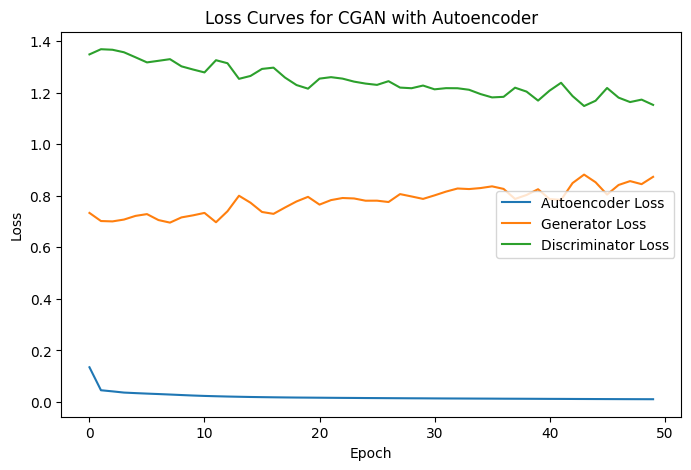

In [103]:
#best paremetes:
batch_size = int(batch_size)

noise_dim = noise_dim
num_epochs = num_epochs
batch_size = batch_size


autoencoder, generator, ae_losses, gen_losses, disc_losses = train_cgan_autoencoder(
    X_train_preprocessed, y_train_onehot,
    noise_dim,
    embed_dim,
    num_epochs,
    batch_size,
    device,
    seed,
    gen_lr,
    disc_lr
)

# Plot the recorded losses
plt.figure(figsize=(8, 5))
plt.plot(ae_losses, label="Autoencoder Loss")
plt.plot(gen_losses, label="Generator Loss")
plt.plot(disc_losses, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves for CGAN with Autoencoder")
plt.legend()
plt.show()


In [104]:
# After the training loop finishes
generator.eval()  # Ensure the generator is in evaluation mode
autoencoder.eval()  # Ensure the autoencoder is in evaluation mode

# 1) Determine the number of synthetic samples (match training dataset size)
num_synthetic_samples = X_train_preprocessed.shape[0]

# Fix the random seed for reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

noise = torch.randn((num_synthetic_samples, noise_dim), device=device) * 0.5

# 2) Prepare conditional labels for synthetic data
synthetic_labels = torch.tensor(y_train_onehot).float().to(device)

# 3) Generate synthetic embeddings using the generator with conditional labels
with torch.no_grad():
    synthetic_embeddings = generator(noise, synthetic_labels)

# 4) Decode the embeddings to reconstruct synthetic data with conditional labels
with torch.no_grad():
    synthetic_data_tensor = autoencoder.decoder(torch.cat([synthetic_embeddings, synthetic_labels], dim=1))

# 5) Convert the synthetic data to a NumPy array for post-processing
synthetic_data = synthetic_data_tensor.cpu().numpy()

# Print the shape of the synthetic dataset
print(f"Synthetic dataset generated with shape: {synthetic_data.shape}")

synthetic_data_copy = synthetic_data.copy()


Synthetic dataset generated with shape: (26048, 108)


In [105]:
# Fix the random seed for reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Separate continuous and categorical features based on training data
num_continuous_features = len(continuous_features)

# Extract continuous features
synthetic_continuous = synthetic_data[:, :num_continuous_features]

# Add slight noise to reduce overfitting while avoiding negative values
synthetic_continuous += np.random.normal(0, 0.05, synthetic_continuous.shape)
synthetic_continuous = scaler.inverse_transform(synthetic_continuous)

# Ensure no negative values for specific continuous features
non_negative_features = ['capital-gain', 'capital-loss']
for feature in non_negative_features:
    if feature in continuous_features:
        feature_index = continuous_features.index(feature)
        synthetic_continuous[:, feature_index] = np.clip(synthetic_continuous[:, feature_index], 0, None)

# Extract categorical features and reverse one-hot encoding
synthetic_categorical_data = synthetic_data[:, num_continuous_features:]
synthetic_categorical = oh_encoder.inverse_transform(synthetic_categorical_data)

# Ensure correct formatting of categorical data
synthetic_categorical_df = pd.DataFrame(synthetic_categorical, columns=categorical_features)

# Introduce diversity to categorical features using real data distribution
for col in categorical_features:
    unique_values = X_train_3[col].dropna().unique()
    probabilities = X_train_3[col].value_counts(normalize=True).to_dict()
    valid_values = [val for val in unique_values if val in probabilities]

    synthetic_categorical_df[col] = np.random.choice(
        valid_values,
        size=len(synthetic_categorical_df),
        replace=True,
        p=[probabilities[val] for val in valid_values]
    )

# Shuffle categorical values to introduce diversity
synthetic_categorical_df = synthetic_categorical_df.sample(frac=1).reset_index(drop=True)

# Combine continuous and categorical features
synthetic_combined = np.hstack([synthetic_continuous, synthetic_categorical_df])

# Create final synthetic DataFrame
synthetic_df = pd.DataFrame(
    synthetic_combined,
    columns=continuous_features + categorical_features
)

# Convert categorical columns to their original types
for col in categorical_features:
    synthetic_df[col] = synthetic_df[col].astype(str)

# Print the shape and preview the synthetic dataset
print(f"Synthetic Dataset Shape (Post-Processed): {synthetic_df.shape}")
print(synthetic_df.head())

synthetic_df_copy = synthetic_df.copy()


Synthetic Dataset Shape (Post-Processed): (26048, 14)
         age         fnlwgt education-num capital-gain capital-loss  \
0  50.665081       374070.0     11.839729          0.0   138.377563   
1  42.253284   221390.53125      7.970152          0.0          0.0   
2  45.540134    392893.6875      7.934843          0.0          0.0   
3  46.565456       197365.0      7.236841          0.0   373.784912   
4  38.817749  215100.109375      8.471169          0.0          0.0   

  hours-per-week         workclass education      marital-status  \
0      45.083672  Self-emp-not-inc   Masters       Never-married   
1      50.133999           Private   HS-grad       Never-married   
2      38.033733           Private   HS-grad  Married-civ-spouse   
3      46.990311           Private   HS-grad       Never-married   
4      44.672348           Private   HS-grad  Married-civ-spouse   

         occupation   relationship   race     sex native-country  
0             Sales      Own-child  White  

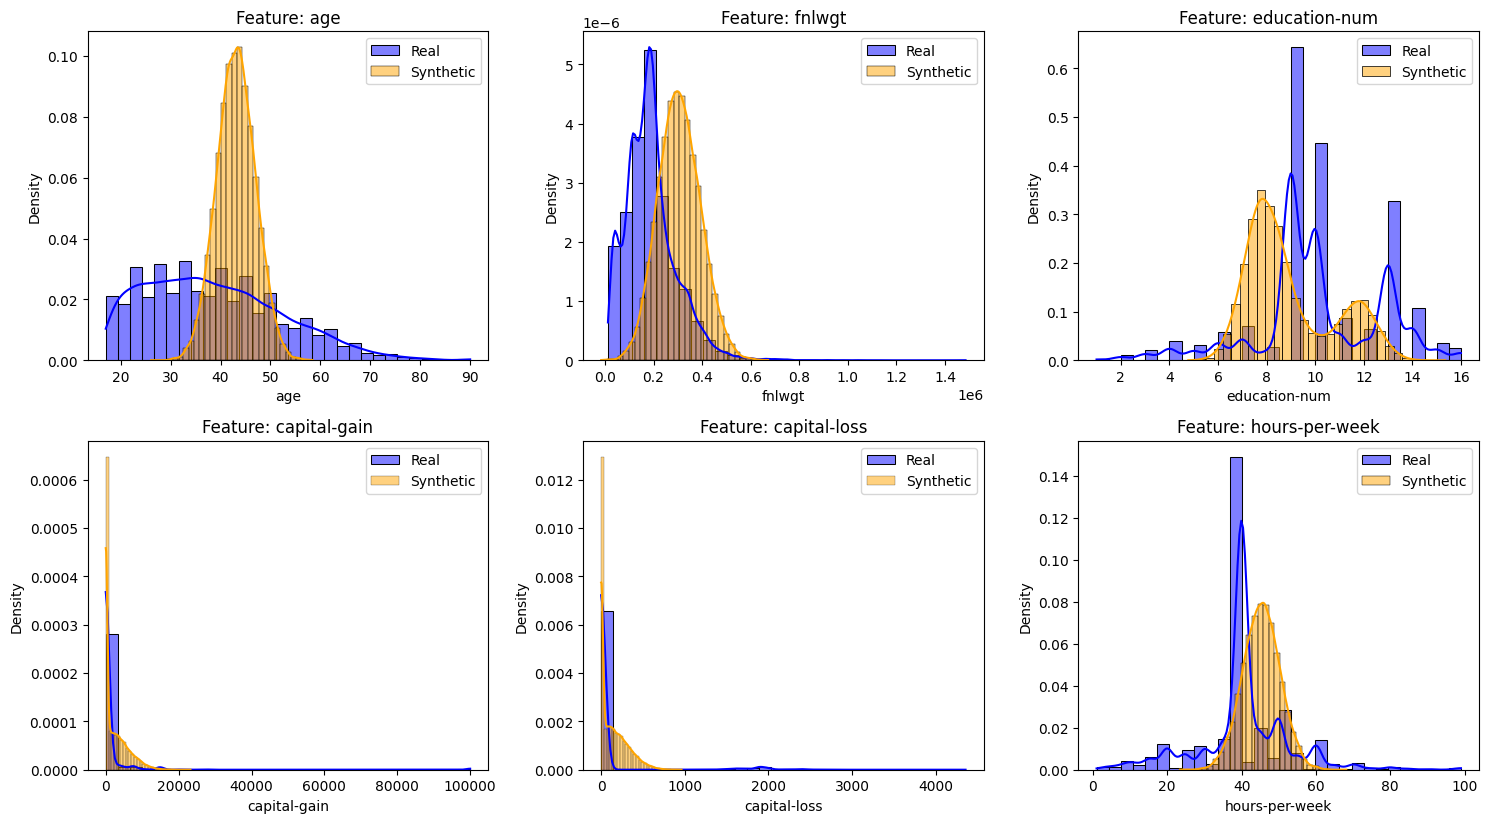

In [106]:
# Number of features
num_features = len(continuous_features)

# Create a grid of subplots
fig, axes = plt.subplots(nrows=(num_features // 3) + 1, ncols=3, figsize=(15, num_features * 2))

# Flatten axes for easier iteration
axes = axes.flatten()

# Loop through each feature
for idx, feature in enumerate(continuous_features):
    ax = axes[idx]

    # Real data column
    real_data_col = X_train_3[feature]  # Adjust if the real data structure differs
    sns.histplot(real_data_col, color='blue', kde=True, label='Real', stat='density', bins=30, ax=ax)

    # Synthetic data column from synthetic_df_copy
    synthetic_data_col = synthetic_df_copy[feature]
    sns.histplot(synthetic_data_col, color='orange', kde=True, label='Synthetic', stat='density', bins=30, ax=ax)

    # Set title and labels
    ax.set_title(f"Feature: {feature}")
    ax.set_xlabel(feature)
    ax.set_ylabel("Density")
    ax.legend()

# Remove any unused subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


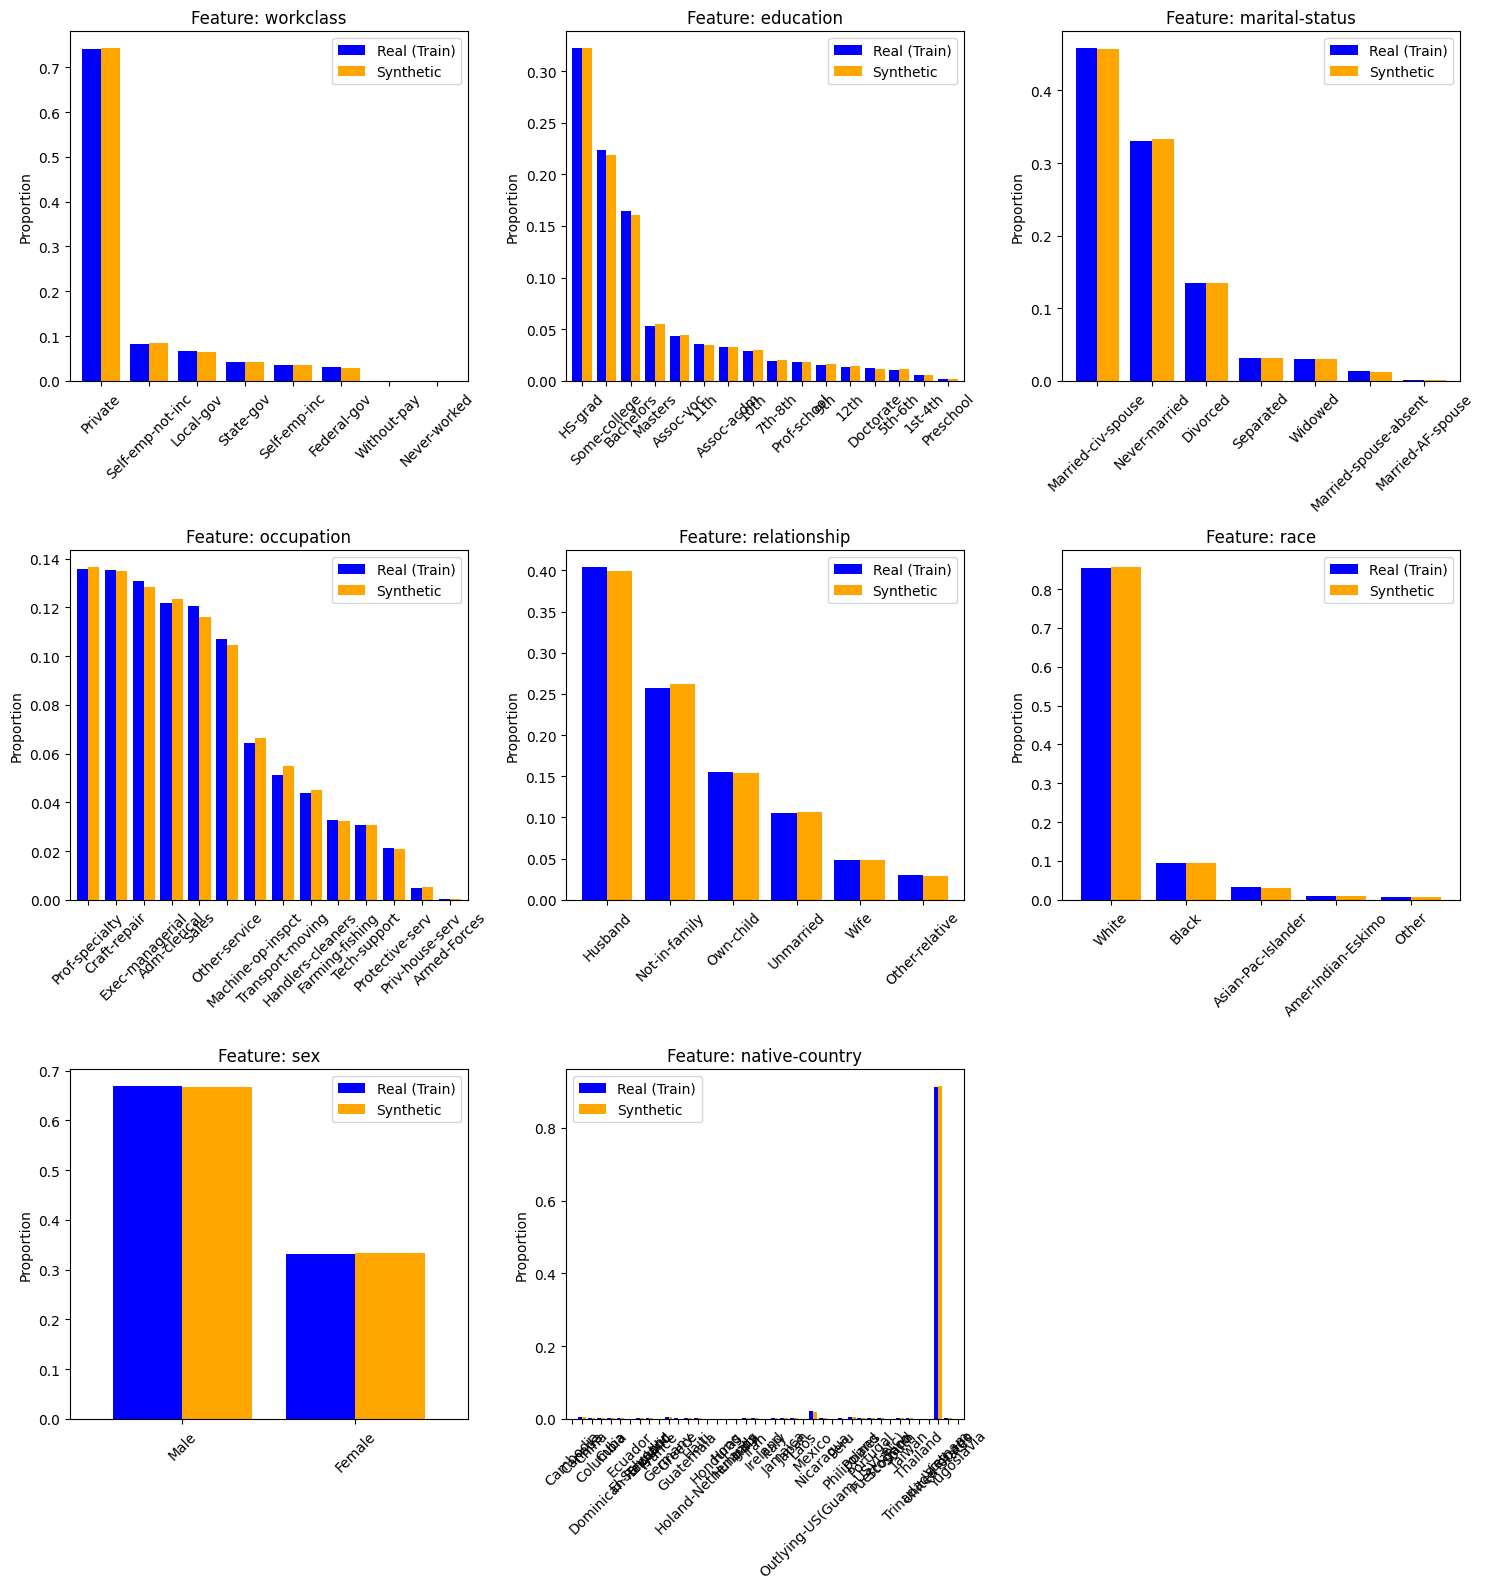

In [107]:
# Number of features
num_features = len(categorical_features)

# Create a grid of subplots
fig, axes = plt.subplots(nrows=(num_features // 3) + 1, ncols=3, figsize=(15, num_features * 2))

# Flatten axes for easier iteration
axes = axes.flatten()

# Loop through each categorical feature
for idx, feature in enumerate(categorical_features):
    ax = axes[idx]

    # Real distribution
    real_counts = X_train_3[feature].value_counts(normalize=True)

    # Synthetic distribution
    synth_counts = synthetic_df_copy[feature].value_counts(normalize=True)

    # Combine and plot
    comparison_df = pd.DataFrame({'Real (Train)': real_counts, 'Synthetic': synth_counts}).fillna(0)
    comparison_df.plot(kind='bar', width=0.8, ax=ax, color=['blue', 'orange'])

    # Set title and labels
    ax.set_title(f"Feature: {feature}")
    ax.set_ylabel("Proportion")
    ax.set_xlabel("")
    ax.tick_params(axis='x', rotation=45)

    # Add legend
    ax.legend()

# Remove any unused subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


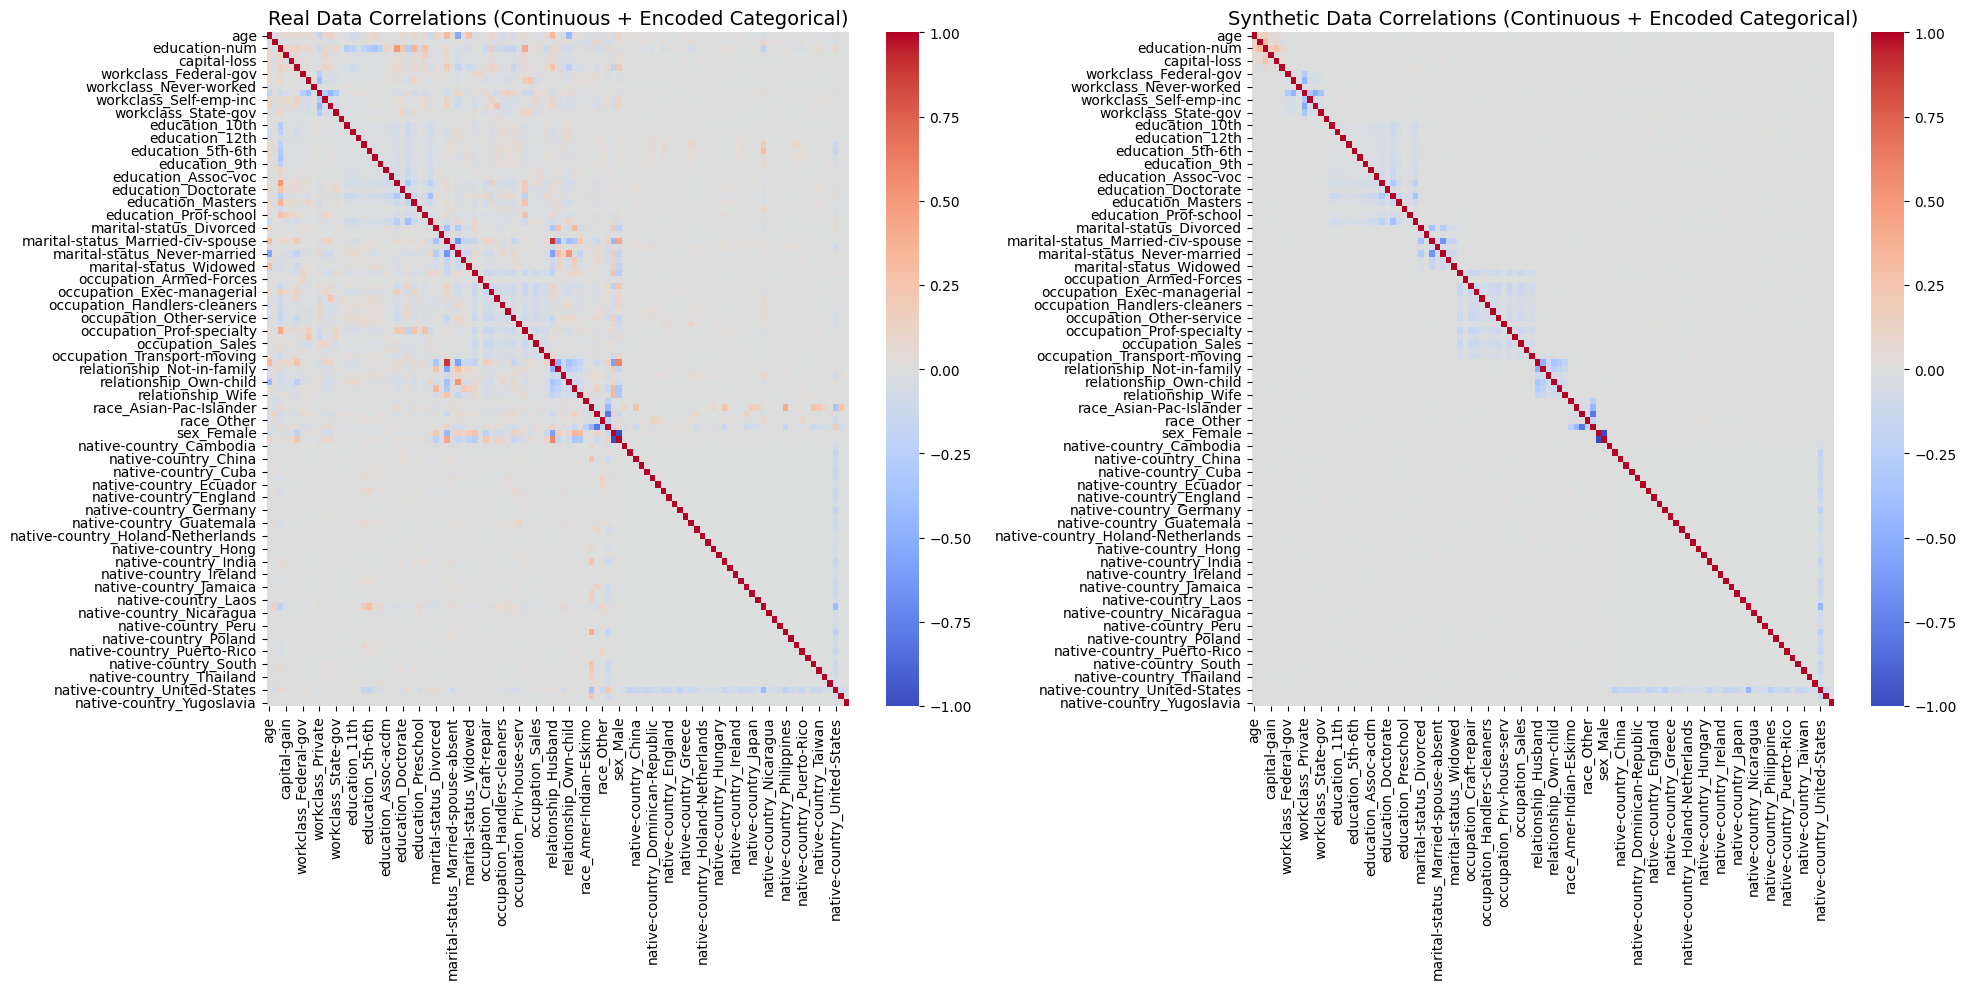

In [108]:
# Combine continuous and one-hot-encoded categorical features
combined_features = pd.concat(
    [X_train_3[continuous_features], pd.get_dummies(X_train_3[categorical_features], drop_first=False)],
    axis=1
)

# Calculate correlations for real data
real_corr = combined_features.corr()

# For synthetic data
synthetic_combined_features = pd.concat(
    [synthetic_df_copy[continuous_features], pd.get_dummies(synthetic_df_copy[categorical_features], drop_first=False)],
    axis=1
)
synthetic_corr = synthetic_combined_features.corr()

# Plot Side-by-Side Correlation Heatmaps
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Real Data Correlations
sns.heatmap(real_corr, ax=axes[0], cmap="coolwarm", cbar=True, annot=False)
axes[0].set_title("Real Data Correlations (Continuous + Encoded Categorical)", fontsize=14)

# Synthetic Data Correlations
sns.heatmap(synthetic_corr, ax=axes[1], cmap="coolwarm", cbar=True, annot=False)
axes[1].set_title("Synthetic Data Correlations (Continuous + Encoded Categorical)", fontsize=14)

plt.tight_layout()
plt.show()


ממוצע עבור 3 הסידים:

In [109]:
# Print the results
print("efficacy:")
print(f"seed1: {efficacy_ratio_first_seed:.4f}")
print(f"seed2: {efficacy_ratio_second_seed:.4f}")
print(f"seed3: {efficacy_ratio_third_seed:.4f}")

efficacy:
seed1: 0.9192
seed2: 0.9044
seed3: 0.9234


In [110]:
# Store results for each seed in lists
efficacy_ratios = [efficacy_ratio_first_seed, efficacy_ratio_second_seed, efficacy_ratio_third_seed]
detection_aucs = [detection_auc_first_seed, detection_auc_second_seed, detection_auc_third_seed]

# Calculate the averages
avg_efficacy_ratio = sum(efficacy_ratios) / len(efficacy_ratios)
avg_detection_auc = sum(detection_aucs) / len(detection_aucs)

# Print the results
print(f"Average Efficacy Ratio across 3 seeds: {avg_efficacy_ratio:.4f}")
print(f"Average Detection AUC across 3 seeds: {avg_detection_auc:.4f}")


Average Efficacy Ratio across 3 seeds: 0.9157
Average Detection AUC across 3 seeds: 1.0000
